In [1]:
%tensorflow_version 1.x
import tensorflow
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

seed = 42
np.random.seed(seed)
% matplotlib inline

TensorFlow 1.x selected.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
os.chdir('/content')
from google.colab import files
keys = files.upload()

Saving ssh.tar.gz to ssh.tar.gz


In [5]:
!rm -rf /root/.ssh
!mkdir /root/.ssh

!tar xvzf ssh.tar.gz

!cp ssh-colab/* /root/.ssh && rm -rf ssh-colab
!chmod 700 /root/.ssh

!touch /root/.ssh/known_hosts
!ssh-keyscan github.com >> /root/.ssh/known_hosts
!chmod 644 /root/.ssh/known_hosts

ssh-colab/
ssh-colab/config
ssh-colab/id_rsa_colab
ssh-colab/id_rsa_colab.pub
# github.com:22 SSH-2.0-babeld-72deb3a2
# github.com:22 SSH-2.0-babeld-72deb3a2
# github.com:22 SSH-2.0-babeld-72deb3a2


In [6]:
!ssh-agent /bin/bash
#ssh-add /root/.ssh/id_rsa_colab
#ssh-add -l
#exit

bash: cannot set terminal process group (141): Inappropriate ioctl for device
bash: no job control in this shell
]0;root@1b21e3095140: /contentroot@1b21e3095140:/content# ssh-add /root/.ssh/id_rsa_colab
Identity added: /root/.ssh/id_rsa_colab (/root/.ssh/id_rsa_colab)
]0;root@1b21e3095140: /contentroot@1b21e3095140:/content# ssh-add -l
2048 SHA256:SpU/DuMOwLsZmS9hdQfImWud0o5YhuYTkxLgNOtF1aA /root/.ssh/id_rsa_colab (RSA)
]0;root@1b21e3095140: /contentroot@1b21e3095140:/content# exit
exit


In [0]:
!git config --global user.email 'rashmi.raviprasad@gmail.com'
!git config --global user.name 'rashmi-raviprasad'

In [0]:
IMAGE_DIRECTORY = '/content/drive/My Drive/Springboard DS Course/CAPSTONE 2/IMAGES/NEW_FINAL_PICS'
REPOSITORY = '/content/drive/My Drive/Springboard DS Course/REPOSITORY/springboard'
os.chdir(REPOSITORY+'/faces_capstone2')

In [4]:
from keras.models import Sequential

class Decoder(Sequential):
  def load_data(self, cat_dir, face_dir, n_images=1000):
    self.imgs = []
    cat_samples = np.random.choice(cat_dir, int(n_images/2), replace=False)
    face_samples = np.random.choice(face_dir, int(n_images/2), replace=False)
    all_samples = np.concatenate((cat_samples, face_samples))
    try:
      for file in tqdm(all_samples):
        fn = IMAGE_DIRECTORY + '/' + file
        img = cv2.imread(fn)
        rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.imgs.append(rgb_image.astype(np.float32) / 255.)
    except:
      print(file)
    np.random.shuffle(self.imgs)
    x_all = np.arange(len(self.imgs))
    self.all_dim = np.asarray(self.imgs).shape[0]
    X = np.array(x_all)
    y = np.array(self.imgs)
    self.X = X
    self.y = y
    return X, y
  def build_model(self, n_components, model_filename, log_filename, n_dim=1000, decoder=None):
    os.chdir(REPOSITORY+'/faces_capstone2')
    decoder = Sequential()
    decoder.add(Embedding(input_dim=n_dim, output_dim=n_components, input_length=1))
    decoder.add(Flatten())
    decoder.add(Reshape((1, 1, n_components)))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=1, activation='relu'))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=1, activation='relu'))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=3, strides=1, activation='relu'))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=16, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=16, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=8, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=3, kernel_size=4, strides=2, activation='sigmoid'))
    decoder.compile(optimizer='adam', loss='mse')
    self.model_filename = model_filename
    decoder.save(self.model_filename)
    self.decoder = decoder
    self.log_filename = log_filename
    train_log = pd.DataFrame(columns=['Date', 'Run_Number', 'Num_Epochs_Tot', 
                                      'Train_Loss', 'Valid_Loss'])
    init_data = {'Date':datetime.now(), 'Run_Number':0, 'Num_Epochs_Tot':0, 'Train_Loss':None, 
                 'Valid_Loss':None}
    train_log.loc[len(train_log)] = list(init_data.values())
    train_log.to_csv(self.log_filename, index=False)
  def fit_model(self, X, y, i, model_filename, log_filename, batch_size, n_epochs, tot_epochs):
    os.chdir(REPOSITORY+'/faces_capstone2')
    model = load_model(model_filename)
    model_hist = model.fit(X, y, batch_size=batch_size, epochs=n_epochs, validation_split=0.2)
    model.save(model_filename)
    train_log = pd.read_csv(log_filename)
    #current_epoch = train_log['Num_Epochs_Tot'].iloc[-1]
    #self.batch_num = train_log['Run_Number'].iloc[-1]
    data_dict = {'Date':datetime.now(), 'Run_Number':(i+1), 'Num_Epochs_Tot':n_epochs*(i+1), 
                 'Train_Loss':model_hist.history['loss'][-1], 'Valid_Loss':model_hist.history['val_loss'][-1]}
    train_log.loc[len(train_log)] = list(data_dict.values())
    train_log.to_csv(log_filename, index=False)
    #self.epochs_remaining = tot_epochs - current_epoch
  def predict_model(self, X, y, model_filename, batch_size):
    os.chdir(REPOSITORY+'/faces_capstone2')
    self.decoder = load_model(model_filename)
    return self.decoder.predict(X, batch_size=batch_size)

Using TensorFlow backend.


In [0]:
def save_to_git(commit_msg):
  os.chdir(REPOSITORY)
  os.environ['MSG'] = commit_msg
  !git pull
  !git add .
  !git commit -m $MSG
  !git push

In [17]:
decoder_model = Decoder()
#decoder_model.load_data()

img_list = os.listdir(IMAGE_DIRECTORY)
cat_dir = []
face_dir = []
for filename in tqdm(img_list):
  if '_' in filename:
    cat_dir.append(filename)
  else:
    face_dir.append(filename)

100%|██████████| 56709/56709 [00:00<00:00, 2109558.10it/s]


In [18]:
#from keras.models import Sequential
from keras.layers import Activation, Input, Flatten, Reshape
from keras.layers.convolutional import Conv2DTranspose
from keras.layers.embeddings import Embedding
from keras.callbacks import TensorBoard
from keras import backend as K
K.set_image_data_format('channels_last')
K.clear_session()

In [0]:
BATCH_SIZE = 32 #make it like 32 or 64 or something
N_COMPONENTS = 100
MODEL_FN = 'decoder.h5'
LOGS_FN = 'train_log.csv'
N_EPOCHS = 20
N_IMAGES = 500

#decoder_model.build_model(N_COMPONENTS, MODEL_FN, LOGS_FN, n_dim=N_IMAGES)

In [0]:
from keras.models import load_model

#codeparade had 1769 images, augmented them to make 35,380 samples.
#he used 2000 epochs, so tot num of imgs seen by his network was 70,760,000.
#I am using pulls of 500 imgs and 20 epochs per pull. In order to
#match num of imgs seen by my network to his, I need to pull from the 
#dataset 7,076 times.

N_PULLS = 7076
N_TOT_EPOCHS = N_EPOCHS * N_PULLS
N_EPOCHS_REMAINING = N_TOT_EPOCHS
log = pd.read_csv(LOGS_FN)
i = len(log)
while N_EPOCHS_REMAINING > 0:
  log = pd.read_csv(LOGS_FN)
  print('Loading %d images' % N_IMAGES)
  X, y = decoder_model.load_data(cat_dir, face_dir, n_images=N_IMAGES)
  print('Training Batch # %d' % (i+1))
  decoder_model.fit_model(X, y, i, MODEL_FN, LOGS_FN, BATCH_SIZE, N_EPOCHS, N_TOT_EPOCHS)
  #message = 'trained %d of %d epochs' % (N_EPOCHS*(i+1), N_TOT_EPOCHS)
  #message = message.replace(' ', '_')
  #if (i+1) % 25 == 0:
  #  save_to_git(message)
  print('Trained %d epochs for total of %d epochs' % (N_EPOCHS, N_EPOCHS*(i+1)))
  N_EPOCHS_REMAINING = N_TOT_EPOCHS - N_EPOCHS*(i+1)
  i += 1

  0%|          | 0/500 [00:00<?, ?it/s]

Loading 500 images


100%|██████████| 500/500 [03:16<00:00,  2.55it/s]


Training Batch # 1318











Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 18ms/step - loss: 0.0697 - val_loss: 0.0760
Epoch 2/20
400/400 [==============================] - 0s 872us/step - loss: 0.0673 - val_loss: 0.0729
Epoch 3/20
400/400 [==============================] - 0s 872us/step - loss: 0.0660 - val_loss: 0.0738
Epoch 4/20
400/400 [==============================] - 0s 867us/step - loss: 0.0651 - val_loss: 0.0731
Epoch 5/20
400/400 [==============================] - 0s 871us/step - loss: 0.0646 - val_loss: 0.0723
Epoch 6/20
400/400 [==============================] - 0s 860us/step - loss: 0.0642 - val_loss: 0.0728
Epoch 7/20
400/400 [==============================] - 0s 865us/step - loss: 0.0639 - val_loss: 0.0732
Epoch 8/20
400/400 [==============================] - 0s 861us/step - loss: 0.0636 - val_loss: 0.0735
Epoch 9/20
400/400 [==============================] - 0s 908us/step - loss: 0.0634 - val_loss: 0.0742
Epoc

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26360 epochs
Loading 500 images


100%|██████████| 500/500 [02:34<00:00,  3.23it/s]


Training Batch # 1319
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 2ms/step - loss: 0.0681 - val_loss: 0.0749
Epoch 2/20
400/400 [==============================] - 0s 910us/step - loss: 0.0656 - val_loss: 0.0743
Epoch 3/20
400/400 [==============================] - 0s 952us/step - loss: 0.0642 - val_loss: 0.0746
Epoch 4/20
400/400 [==============================] - 0s 890us/step - loss: 0.0634 - val_loss: 0.0735
Epoch 5/20
400/400 [==============================] - 0s 915us/step - loss: 0.0629 - val_loss: 0.0742
Epoch 6/20
400/400 [==============================] - 0s 924us/step - loss: 0.0625 - val_loss: 0.0751
Epoch 7/20
400/400 [==============================] - 0s 916us/step - loss: 0.0622 - val_loss: 0.0746
Epoch 8/20
400/400 [==============================] - 0s 922us/step - loss: 0.0619 - val_loss: 0.0751
Epoch 9/20
400/400 [==============================] - 0s 911us/step - loss: 0.0615 - val_loss: 0.0756
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26380 epochs
Loading 500 images


100%|██████████| 500/500 [02:48<00:00,  2.97it/s]


Training Batch # 1320
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 2ms/step - loss: 0.0684 - val_loss: 0.0746
Epoch 2/20
400/400 [==============================] - 0s 900us/step - loss: 0.0660 - val_loss: 0.0737
Epoch 3/20
400/400 [==============================] - 0s 897us/step - loss: 0.0646 - val_loss: 0.0750
Epoch 4/20
400/400 [==============================] - 0s 918us/step - loss: 0.0639 - val_loss: 0.0739
Epoch 5/20
400/400 [==============================] - 0s 922us/step - loss: 0.0633 - val_loss: 0.0741
Epoch 6/20
400/400 [==============================] - 0s 911us/step - loss: 0.0629 - val_loss: 0.0746
Epoch 7/20
400/400 [==============================] - 0s 908us/step - loss: 0.0625 - val_loss: 0.0746
Epoch 8/20
400/400 [==============================] - 0s 909us/step - loss: 0.0622 - val_loss: 0.0756
Epoch 9/20
400/400 [==============================] - 0s 967us/step - loss: 0.0619 - val_loss: 0.0757
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26400 epochs
Loading 500 images


100%|██████████| 500/500 [02:32<00:00,  3.28it/s]


Training Batch # 1321
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 2ms/step - loss: 0.0718 - val_loss: 0.0757
Epoch 2/20
400/400 [==============================] - 0s 895us/step - loss: 0.0695 - val_loss: 0.0750
Epoch 3/20
400/400 [==============================] - 0s 901us/step - loss: 0.0681 - val_loss: 0.0754
Epoch 4/20
400/400 [==============================] - 0s 865us/step - loss: 0.0673 - val_loss: 0.0754
Epoch 5/20
400/400 [==============================] - 0s 847us/step - loss: 0.0668 - val_loss: 0.0754
Epoch 6/20
400/400 [==============================] - 0s 869us/step - loss: 0.0665 - val_loss: 0.0757
Epoch 7/20
400/400 [==============================] - 0s 866us/step - loss: 0.0662 - val_loss: 0.0763
Epoch 8/20
400/400 [==============================] - 0s 889us/step - loss: 0.0659 - val_loss: 0.0761
Epoch 9/20
400/400 [==============================] - 0s 872us/step - loss: 0.0656 - val_loss: 0.0767
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26420 epochs
Loading 500 images


100%|██████████| 500/500 [02:36<00:00,  3.20it/s]


Training Batch # 1322
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0713 - val_loss: 0.0730
Epoch 2/20
400/400 [==============================] - 0s 884us/step - loss: 0.0692 - val_loss: 0.0705
Epoch 3/20
400/400 [==============================] - 0s 880us/step - loss: 0.0676 - val_loss: 0.0719
Epoch 4/20
400/400 [==============================] - 0s 907us/step - loss: 0.0671 - val_loss: 0.0713
Epoch 5/20
400/400 [==============================] - 0s 891us/step - loss: 0.0665 - val_loss: 0.0711
Epoch 6/20
400/400 [==============================] - 0s 889us/step - loss: 0.0661 - val_loss: 0.0716
Epoch 7/20
400/400 [==============================] - 0s 881us/step - loss: 0.0658 - val_loss: 0.0732
Epoch 8/20
400/400 [==============================] - 0s 901us/step - loss: 0.0655 - val_loss: 0.0731
Epoch 9/20
400/400 [==============================] - 0s 906us/step - loss: 0.0652 - val_loss: 0.0732
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26440 epochs
Loading 500 images


100%|██████████| 500/500 [02:24<00:00,  3.46it/s]


Training Batch # 1323
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0696 - val_loss: 0.0711
Epoch 2/20
400/400 [==============================] - 0s 936us/step - loss: 0.0672 - val_loss: 0.0714
Epoch 3/20
400/400 [==============================] - 0s 912us/step - loss: 0.0660 - val_loss: 0.0727
Epoch 4/20
400/400 [==============================] - 0s 906us/step - loss: 0.0653 - val_loss: 0.0715
Epoch 5/20
400/400 [==============================] - 0s 894us/step - loss: 0.0649 - val_loss: 0.0714
Epoch 6/20
400/400 [==============================] - 0s 931us/step - loss: 0.0646 - val_loss: 0.0726
Epoch 7/20
400/400 [==============================] - 0s 931us/step - loss: 0.0643 - val_loss: 0.0722
Epoch 8/20
400/400 [==============================] - 0s 910us/step - loss: 0.0640 - val_loss: 0.0728
Epoch 9/20
400/400 [==============================] - 0s 925us/step - loss: 0.0636 - val_loss: 0.0734
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26460 epochs
Loading 500 images


100%|██████████| 500/500 [02:34<00:00,  3.24it/s]


Training Batch # 1324
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0678 - val_loss: 0.0713
Epoch 2/20
400/400 [==============================] - 0s 912us/step - loss: 0.0658 - val_loss: 0.0702
Epoch 3/20
400/400 [==============================] - 0s 936us/step - loss: 0.0645 - val_loss: 0.0707
Epoch 4/20
400/400 [==============================] - 0s 910us/step - loss: 0.0640 - val_loss: 0.0704
Epoch 5/20
400/400 [==============================] - 0s 882us/step - loss: 0.0634 - val_loss: 0.0707
Epoch 6/20
400/400 [==============================] - 0s 911us/step - loss: 0.0631 - val_loss: 0.0707
Epoch 7/20
400/400 [==============================] - 0s 933us/step - loss: 0.0627 - val_loss: 0.0708
Epoch 8/20
400/400 [==============================] - 0s 918us/step - loss: 0.0624 - val_loss: 0.0710
Epoch 9/20
400/400 [==============================] - 0s 903us/step - loss: 0.0621 - val_loss: 0.0709
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26480 epochs
Loading 500 images


100%|██████████| 500/500 [02:31<00:00,  3.29it/s]


Training Batch # 1325
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0698 - val_loss: 0.0798
Epoch 2/20
400/400 [==============================] - 0s 944us/step - loss: 0.0674 - val_loss: 0.0758
Epoch 3/20
400/400 [==============================] - 0s 914us/step - loss: 0.0660 - val_loss: 0.0772
Epoch 4/20
400/400 [==============================] - 0s 970us/step - loss: 0.0651 - val_loss: 0.0764
Epoch 5/20
400/400 [==============================] - 0s 962us/step - loss: 0.0646 - val_loss: 0.0774
Epoch 6/20
400/400 [==============================] - 0s 943us/step - loss: 0.0643 - val_loss: 0.0779
Epoch 7/20
400/400 [==============================] - 0s 958us/step - loss: 0.0638 - val_loss: 0.0765
Epoch 8/20
400/400 [==============================] - 0s 958us/step - loss: 0.0634 - val_loss: 0.0791
Epoch 9/20
400/400 [==============================] - 0s 945us/step - loss: 0.0631 - val_loss: 0.0783
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26500 epochs
Loading 500 images


100%|██████████| 500/500 [03:12<00:00,  2.60it/s]


Training Batch # 1326
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 3ms/step - loss: 0.0690 - val_loss: 0.0742
Epoch 2/20
400/400 [==============================] - 0s 893us/step - loss: 0.0665 - val_loss: 0.0731
Epoch 3/20
400/400 [==============================] - 0s 904us/step - loss: 0.0653 - val_loss: 0.0734
Epoch 4/20
400/400 [==============================] - 0s 885us/step - loss: 0.0648 - val_loss: 0.0723
Epoch 5/20
400/400 [==============================] - 0s 922us/step - loss: 0.0642 - val_loss: 0.0738
Epoch 6/20
400/400 [==============================] - 0s 890us/step - loss: 0.0640 - val_loss: 0.0726
Epoch 7/20
400/400 [==============================] - 0s 929us/step - loss: 0.0634 - val_loss: 0.0744
Epoch 8/20
400/400 [==============================] - 0s 913us/step - loss: 0.0631 - val_loss: 0.0742
Epoch 9/20
400/400 [==============================] - 0s 848us/step - loss: 0.0628 - val_loss: 0.0751
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26520 epochs
Loading 500 images


100%|██████████| 500/500 [03:16<00:00,  2.54it/s]


Training Batch # 1327
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 1s 4ms/step - loss: 0.0722 - val_loss: 0.0713
Epoch 2/20
400/400 [==============================] - 0s 872us/step - loss: 0.0692 - val_loss: 0.0692
Epoch 3/20
400/400 [==============================] - 0s 900us/step - loss: 0.0672 - val_loss: 0.0694
Epoch 4/20
400/400 [==============================] - 0s 868us/step - loss: 0.0665 - val_loss: 0.0699
Epoch 5/20
400/400 [==============================] - 0s 874us/step - loss: 0.0660 - val_loss: 0.0696
Epoch 6/20
400/400 [==============================] - 0s 873us/step - loss: 0.0655 - val_loss: 0.0694
Epoch 7/20
400/400 [==============================] - 0s 878us/step - loss: 0.0651 - val_loss: 0.0704
Epoch 8/20
400/400 [==============================] - 0s 919us/step - loss: 0.0648 - val_loss: 0.0710
Epoch 9/20
400/400 [==============================] - 0s 869us/step - loss: 0.0644 - val_loss: 0.0716
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26540 epochs
Loading 500 images


100%|██████████| 500/500 [02:24<00:00,  3.46it/s]


Training Batch # 1328
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 4ms/step - loss: 0.0703 - val_loss: 0.0729
Epoch 2/20
400/400 [==============================] - 0s 911us/step - loss: 0.0673 - val_loss: 0.0716
Epoch 3/20
400/400 [==============================] - 0s 881us/step - loss: 0.0659 - val_loss: 0.0732
Epoch 4/20
400/400 [==============================] - 0s 876us/step - loss: 0.0651 - val_loss: 0.0719
Epoch 5/20
400/400 [==============================] - 0s 910us/step - loss: 0.0645 - val_loss: 0.0735
Epoch 6/20
400/400 [==============================] - 0s 918us/step - loss: 0.0641 - val_loss: 0.0729
Epoch 7/20
400/400 [==============================] - 0s 913us/step - loss: 0.0637 - val_loss: 0.0736
Epoch 8/20
400/400 [==============================] - 0s 881us/step - loss: 0.0634 - val_loss: 0.0742
Epoch 9/20
400/400 [==============================] - 0s 907us/step - loss: 0.0629 - val_loss: 0.0752
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26560 epochs
Loading 500 images


100%|██████████| 500/500 [02:27<00:00,  3.40it/s]


Training Batch # 1329
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 4ms/step - loss: 0.0700 - val_loss: 0.0732
Epoch 2/20
400/400 [==============================] - 0s 874us/step - loss: 0.0672 - val_loss: 0.0719
Epoch 3/20
400/400 [==============================] - 0s 882us/step - loss: 0.0657 - val_loss: 0.0718
Epoch 4/20
400/400 [==============================] - 0s 933us/step - loss: 0.0651 - val_loss: 0.0715
Epoch 5/20
400/400 [==============================] - 0s 916us/step - loss: 0.0645 - val_loss: 0.0715
Epoch 6/20
400/400 [==============================] - 0s 914us/step - loss: 0.0641 - val_loss: 0.0714
Epoch 7/20
400/400 [==============================] - 0s 917us/step - loss: 0.0637 - val_loss: 0.0713
Epoch 8/20
400/400 [==============================] - 0s 941us/step - loss: 0.0634 - val_loss: 0.0722
Epoch 9/20
400/400 [==============================] - 0s 936us/step - loss: 0.0631 - val_loss: 0.0728
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26580 epochs
Loading 500 images


100%|██████████| 500/500 [02:00<00:00,  4.14it/s]


Training Batch # 1330
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 4ms/step - loss: 0.0655 - val_loss: 0.0736
Epoch 2/20
400/400 [==============================] - 0s 907us/step - loss: 0.0633 - val_loss: 0.0715
Epoch 3/20
400/400 [==============================] - 0s 940us/step - loss: 0.0619 - val_loss: 0.0723
Epoch 4/20
400/400 [==============================] - 0s 910us/step - loss: 0.0612 - val_loss: 0.0722
Epoch 5/20
400/400 [==============================] - 0s 929us/step - loss: 0.0608 - val_loss: 0.0722
Epoch 6/20
400/400 [==============================] - 0s 950us/step - loss: 0.0604 - val_loss: 0.0725
Epoch 7/20
400/400 [==============================] - 0s 907us/step - loss: 0.0601 - val_loss: 0.0725
Epoch 8/20
400/400 [==============================] - 0s 913us/step - loss: 0.0598 - val_loss: 0.0727
Epoch 9/20
400/400 [==============================] - 0s 936us/step - loss: 0.0596 - val_loss: 0.0737
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26600 epochs
Loading 500 images


100%|██████████| 500/500 [02:11<00:00,  3.79it/s]


Training Batch # 1331
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0686 - val_loss: 0.0705
Epoch 2/20
400/400 [==============================] - 0s 898us/step - loss: 0.0663 - val_loss: 0.0686
Epoch 3/20
400/400 [==============================] - 0s 932us/step - loss: 0.0649 - val_loss: 0.0697
Epoch 4/20
400/400 [==============================] - 0s 908us/step - loss: 0.0642 - val_loss: 0.0701
Epoch 5/20
400/400 [==============================] - 0s 908us/step - loss: 0.0637 - val_loss: 0.0698
Epoch 6/20
400/400 [==============================] - 0s 900us/step - loss: 0.0635 - val_loss: 0.0697
Epoch 7/20
400/400 [==============================] - 0s 920us/step - loss: 0.0631 - val_loss: 0.0705
Epoch 8/20
400/400 [==============================] - 0s 915us/step - loss: 0.0628 - val_loss: 0.0710
Epoch 9/20
400/400 [==============================] - 0s 963us/step - loss: 0.0625 - val_loss: 0.0715
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26620 epochs
Loading 500 images


100%|██████████| 500/500 [02:36<00:00,  3.19it/s]


Training Batch # 1332
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0705 - val_loss: 0.0711
Epoch 2/20
400/400 [==============================] - 0s 932us/step - loss: 0.0679 - val_loss: 0.0698
Epoch 3/20
400/400 [==============================] - 0s 931us/step - loss: 0.0668 - val_loss: 0.0703
Epoch 4/20
400/400 [==============================] - 0s 902us/step - loss: 0.0662 - val_loss: 0.0700
Epoch 5/20
400/400 [==============================] - 0s 915us/step - loss: 0.0657 - val_loss: 0.0700
Epoch 6/20
400/400 [==============================] - 0s 943us/step - loss: 0.0652 - val_loss: 0.0705
Epoch 7/20
400/400 [==============================] - 0s 932us/step - loss: 0.0649 - val_loss: 0.0708
Epoch 8/20
400/400 [==============================] - 0s 921us/step - loss: 0.0645 - val_loss: 0.0716
Epoch 9/20
400/400 [==============================] - 0s 915us/step - loss: 0.0642 - val_loss: 0.0721
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26640 epochs
Loading 500 images


100%|██████████| 500/500 [01:55<00:00,  4.32it/s]


Training Batch # 1333
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0697 - val_loss: 0.0708
Epoch 2/20
400/400 [==============================] - 0s 923us/step - loss: 0.0667 - val_loss: 0.0723
Epoch 3/20
400/400 [==============================] - 0s 929us/step - loss: 0.0651 - val_loss: 0.0706
Epoch 4/20
400/400 [==============================] - 0s 926us/step - loss: 0.0643 - val_loss: 0.0719
Epoch 5/20
400/400 [==============================] - 0s 902us/step - loss: 0.0638 - val_loss: 0.0718
Epoch 6/20
400/400 [==============================] - 0s 926us/step - loss: 0.0633 - val_loss: 0.0716
Epoch 7/20
400/400 [==============================] - 0s 934us/step - loss: 0.0630 - val_loss: 0.0725
Epoch 8/20
400/400 [==============================] - 0s 931us/step - loss: 0.0626 - val_loss: 0.0730
Epoch 9/20
400/400 [==============================] - 0s 923us/step - loss: 0.0623 - val_loss: 0.0739
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26660 epochs
Loading 500 images


100%|██████████| 500/500 [01:52<00:00,  4.46it/s]


Training Batch # 1334
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0675 - val_loss: 0.0722
Epoch 2/20
400/400 [==============================] - 0s 916us/step - loss: 0.0646 - val_loss: 0.0707
Epoch 3/20
400/400 [==============================] - 0s 913us/step - loss: 0.0630 - val_loss: 0.0709
Epoch 4/20
400/400 [==============================] - 0s 906us/step - loss: 0.0622 - val_loss: 0.0706
Epoch 5/20
400/400 [==============================] - 0s 912us/step - loss: 0.0615 - val_loss: 0.0709
Epoch 6/20
400/400 [==============================] - 0s 913us/step - loss: 0.0610 - val_loss: 0.0712
Epoch 7/20
400/400 [==============================] - 0s 895us/step - loss: 0.0608 - val_loss: 0.0715
Epoch 8/20
400/400 [==============================] - 0s 915us/step - loss: 0.0603 - val_loss: 0.0727
Epoch 9/20
400/400 [==============================] - 0s 886us/step - loss: 0.0599 - val_loss: 0.0725
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26680 epochs
Loading 500 images


100%|██████████| 500/500 [01:56<00:00,  4.30it/s]


Training Batch # 1335
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 6ms/step - loss: 0.0701 - val_loss: 0.0702
Epoch 2/20
400/400 [==============================] - 0s 936us/step - loss: 0.0668 - val_loss: 0.0706
Epoch 3/20
400/400 [==============================] - 0s 918us/step - loss: 0.0651 - val_loss: 0.0718
Epoch 4/20
400/400 [==============================] - 0s 897us/step - loss: 0.0641 - val_loss: 0.0699
Epoch 5/20
400/400 [==============================] - 0s 913us/step - loss: 0.0636 - val_loss: 0.0717
Epoch 6/20
400/400 [==============================] - 0s 946us/step - loss: 0.0631 - val_loss: 0.0719
Epoch 7/20
400/400 [==============================] - 0s 882us/step - loss: 0.0627 - val_loss: 0.0716
Epoch 8/20
400/400 [==============================] - 0s 902us/step - loss: 0.0624 - val_loss: 0.0727
Epoch 9/20
400/400 [==============================] - 0s 916us/step - loss: 0.0621 - val_loss: 0.0729
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26700 epochs
Loading 500 images


100%|██████████| 500/500 [02:00<00:00,  4.16it/s]


Training Batch # 1336
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 2s 6ms/step - loss: 0.0699 - val_loss: 0.0790
Epoch 2/20
400/400 [==============================] - 0s 910us/step - loss: 0.0672 - val_loss: 0.0795
Epoch 3/20
400/400 [==============================] - 0s 916us/step - loss: 0.0655 - val_loss: 0.0789
Epoch 4/20
400/400 [==============================] - 0s 930us/step - loss: 0.0646 - val_loss: 0.0786
Epoch 5/20
400/400 [==============================] - 0s 910us/step - loss: 0.0642 - val_loss: 0.0783
Epoch 6/20
400/400 [==============================] - 0s 909us/step - loss: 0.0637 - val_loss: 0.0793
Epoch 7/20
400/400 [==============================] - 0s 903us/step - loss: 0.0633 - val_loss: 0.0791
Epoch 8/20
400/400 [==============================] - 0s 922us/step - loss: 0.0629 - val_loss: 0.0797
Epoch 9/20
400/400 [==============================] - 0s 940us/step - loss: 0.0626 - val_loss: 0.0793
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26720 epochs
Loading 500 images


100%|██████████| 500/500 [02:01<00:00,  4.12it/s]


Training Batch # 1337
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 3s 7ms/step - loss: 0.0669 - val_loss: 0.0690
Epoch 2/20
400/400 [==============================] - 0s 939us/step - loss: 0.0647 - val_loss: 0.0680
Epoch 3/20
400/400 [==============================] - 0s 955us/step - loss: 0.0636 - val_loss: 0.0691
Epoch 4/20
400/400 [==============================] - 0s 961us/step - loss: 0.0629 - val_loss: 0.0689
Epoch 5/20
400/400 [==============================] - 0s 952us/step - loss: 0.0624 - val_loss: 0.0691
Epoch 6/20
400/400 [==============================] - 0s 982us/step - loss: 0.0621 - val_loss: 0.0694
Epoch 7/20
400/400 [==============================] - 0s 947us/step - loss: 0.0617 - val_loss: 0.0701
Epoch 8/20
400/400 [==============================] - 0s 975us/step - loss: 0.0614 - val_loss: 0.0697
Epoch 9/20
400/400 [==============================] - 0s 947us/step - loss: 0.0610 - val_loss: 0.0710
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26740 epochs
Loading 500 images


100%|██████████| 500/500 [01:50<00:00,  4.53it/s]


Training Batch # 1338
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 3s 7ms/step - loss: 0.0711 - val_loss: 0.0688
Epoch 2/20
400/400 [==============================] - 0s 897us/step - loss: 0.0684 - val_loss: 0.0661
Epoch 3/20
400/400 [==============================] - 0s 938us/step - loss: 0.0671 - val_loss: 0.0672
Epoch 4/20
400/400 [==============================] - 0s 906us/step - loss: 0.0664 - val_loss: 0.0683
Epoch 5/20
400/400 [==============================] - 0s 926us/step - loss: 0.0658 - val_loss: 0.0672
Epoch 6/20
400/400 [==============================] - 0s 919us/step - loss: 0.0655 - val_loss: 0.0679
Epoch 7/20
400/400 [==============================] - 0s 927us/step - loss: 0.0652 - val_loss: 0.0675
Epoch 8/20
400/400 [==============================] - 0s 953us/step - loss: 0.0648 - val_loss: 0.0677
Epoch 9/20
400/400 [==============================] - 0s 933us/step - loss: 0.0645 - val_loss: 0.0687
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26760 epochs
Loading 500 images


100%|██████████| 500/500 [02:03<00:00,  4.03it/s]


Training Batch # 1339
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 3s 7ms/step - loss: 0.0698 - val_loss: 0.0698
Epoch 2/20
400/400 [==============================] - 0s 898us/step - loss: 0.0671 - val_loss: 0.0696
Epoch 3/20
400/400 [==============================] - 0s 904us/step - loss: 0.0659 - val_loss: 0.0717
Epoch 4/20
400/400 [==============================] - 0s 917us/step - loss: 0.0651 - val_loss: 0.0706
Epoch 5/20
400/400 [==============================] - 0s 928us/step - loss: 0.0646 - val_loss: 0.0712
Epoch 6/20
400/400 [==============================] - 0s 932us/step - loss: 0.0643 - val_loss: 0.0716
Epoch 7/20
400/400 [==============================] - 0s 900us/step - loss: 0.0638 - val_loss: 0.0715
Epoch 8/20
400/400 [==============================] - 0s 892us/step - loss: 0.0634 - val_loss: 0.0723
Epoch 9/20
400/400 [==============================] - 0s 948us/step - loss: 0.0631 - val_loss: 0.0730
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26780 epochs
Loading 500 images


100%|██████████| 500/500 [02:04<00:00,  4.02it/s]


Training Batch # 1340
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 3s 7ms/step - loss: 0.0700 - val_loss: 0.0704
Epoch 2/20
400/400 [==============================] - 0s 939us/step - loss: 0.0671 - val_loss: 0.0675
Epoch 3/20
400/400 [==============================] - 0s 958us/step - loss: 0.0656 - val_loss: 0.0691
Epoch 4/20
400/400 [==============================] - 0s 923us/step - loss: 0.0647 - val_loss: 0.0691
Epoch 5/20
400/400 [==============================] - 0s 920us/step - loss: 0.0642 - val_loss: 0.0691
Epoch 6/20
400/400 [==============================] - 0s 932us/step - loss: 0.0638 - val_loss: 0.0700
Epoch 7/20
400/400 [==============================] - 0s 945us/step - loss: 0.0636 - val_loss: 0.0707
Epoch 8/20
400/400 [==============================] - 0s 937us/step - loss: 0.0633 - val_loss: 0.0715
Epoch 9/20
400/400 [==============================] - 0s 927us/step - loss: 0.0630 - val_loss: 0.0705
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26800 epochs
Loading 500 images


100%|██████████| 500/500 [01:57<00:00,  4.25it/s]


Training Batch # 1341
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0693 - val_loss: 0.0700
Epoch 2/20
400/400 [==============================] - 0s 953us/step - loss: 0.0665 - val_loss: 0.0698
Epoch 3/20
400/400 [==============================] - 0s 926us/step - loss: 0.0649 - val_loss: 0.0698
Epoch 4/20
400/400 [==============================] - 0s 983us/step - loss: 0.0642 - val_loss: 0.0699
Epoch 5/20
400/400 [==============================] - 0s 952us/step - loss: 0.0636 - val_loss: 0.0711
Epoch 6/20
400/400 [==============================] - 0s 955us/step - loss: 0.0633 - val_loss: 0.0704
Epoch 7/20
400/400 [==============================] - 0s 921us/step - loss: 0.0630 - val_loss: 0.0718
Epoch 8/20
400/400 [==============================] - 0s 931us/step - loss: 0.0625 - val_loss: 0.0705
Epoch 9/20
400/400 [==============================] - 0s 939us/step - loss: 0.0622 - val_loss: 0.0717
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26820 epochs
Loading 500 images


100%|██████████| 500/500 [02:42<00:00,  3.07it/s]


Training Batch # 1342
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0695 - val_loss: 0.0760
Epoch 2/20
400/400 [==============================] - 0s 936us/step - loss: 0.0670 - val_loss: 0.0747
Epoch 3/20
400/400 [==============================] - 0s 938us/step - loss: 0.0655 - val_loss: 0.0773
Epoch 4/20
400/400 [==============================] - 0s 936us/step - loss: 0.0646 - val_loss: 0.0747
Epoch 5/20
400/400 [==============================] - 0s 962us/step - loss: 0.0642 - val_loss: 0.0755
Epoch 6/20
400/400 [==============================] - 0s 918us/step - loss: 0.0637 - val_loss: 0.0768
Epoch 7/20
400/400 [==============================] - 0s 938us/step - loss: 0.0634 - val_loss: 0.0761
Epoch 8/20
400/400 [==============================] - 0s 949us/step - loss: 0.0631 - val_loss: 0.0776
Epoch 9/20
400/400 [==============================] - 0s 927us/step - loss: 0.0627 - val_loss: 0.0781
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26840 epochs
Loading 500 images


100%|██████████| 500/500 [01:58<00:00,  4.22it/s]


Training Batch # 1343
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0679 - val_loss: 0.0631
Epoch 2/20
400/400 [==============================] - 0s 958us/step - loss: 0.0655 - val_loss: 0.0623
Epoch 3/20
400/400 [==============================] - 0s 940us/step - loss: 0.0642 - val_loss: 0.0643
Epoch 4/20
400/400 [==============================] - 0s 955us/step - loss: 0.0634 - val_loss: 0.0626
Epoch 5/20
400/400 [==============================] - 0s 960us/step - loss: 0.0628 - val_loss: 0.0640
Epoch 6/20
400/400 [==============================] - 0s 932us/step - loss: 0.0623 - val_loss: 0.0637
Epoch 7/20
400/400 [==============================] - 0s 963us/step - loss: 0.0620 - val_loss: 0.0646
Epoch 8/20
400/400 [==============================] - 0s 948us/step - loss: 0.0617 - val_loss: 0.0645
Epoch 9/20
400/400 [==============================] - 0s 980us/step - loss: 0.0614 - val_loss: 0.0654
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26860 epochs
Loading 500 images


100%|██████████| 500/500 [01:57<00:00,  4.26it/s]


Training Batch # 1344
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 3s 9ms/step - loss: 0.0689 - val_loss: 0.0743
Epoch 2/20
400/400 [==============================] - 0s 958us/step - loss: 0.0660 - val_loss: 0.0728
Epoch 3/20
400/400 [==============================] - 0s 905us/step - loss: 0.0646 - val_loss: 0.0738
Epoch 4/20
400/400 [==============================] - 0s 939us/step - loss: 0.0640 - val_loss: 0.0738
Epoch 5/20
400/400 [==============================] - 0s 927us/step - loss: 0.0636 - val_loss: 0.0742
Epoch 6/20
400/400 [==============================] - 0s 919us/step - loss: 0.0633 - val_loss: 0.0742
Epoch 7/20
400/400 [==============================] - 0s 949us/step - loss: 0.0628 - val_loss: 0.0738
Epoch 8/20
400/400 [==============================] - 0s 944us/step - loss: 0.0625 - val_loss: 0.0753
Epoch 9/20
400/400 [==============================] - 0s 994us/step - loss: 0.0621 - val_loss: 0.0757
Epoch 10/20
400/

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26880 epochs
Loading 500 images


100%|██████████| 500/500 [01:38<00:00,  5.06it/s]


Training Batch # 1345
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 9ms/step - loss: 0.0710 - val_loss: 0.0671
Epoch 2/20
400/400 [==============================] - 0s 987us/step - loss: 0.0679 - val_loss: 0.0675
Epoch 3/20
400/400 [==============================] - 0s 979us/step - loss: 0.0665 - val_loss: 0.0671
Epoch 4/20
400/400 [==============================] - 0s 969us/step - loss: 0.0656 - val_loss: 0.0673
Epoch 5/20
400/400 [==============================] - 0s 982us/step - loss: 0.0652 - val_loss: 0.0679
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0680
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0681
Epoch 8/20
400/400 [==============================] - 0s 979us/step - loss: 0.0639 - val_loss: 0.0696
Epoch 9/20
400/400 [==============================] - 0s 971us/step - loss: 0.0636 - val_loss: 0.0701
Epoch 10/20
400/400 

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26900 epochs
Loading 500 images


100%|██████████| 500/500 [01:45<00:00,  4.75it/s]


Training Batch # 1346
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 10ms/step - loss: 0.0723 - val_loss: 0.0695
Epoch 2/20
400/400 [==============================] - 0s 969us/step - loss: 0.0699 - val_loss: 0.0674
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0683 - val_loss: 0.0704
Epoch 4/20
400/400 [==============================] - 0s 993us/step - loss: 0.0675 - val_loss: 0.0693
Epoch 5/20
400/400 [==============================] - 0s 975us/step - loss: 0.0668 - val_loss: 0.0703
Epoch 6/20
400/400 [==============================] - 0s 967us/step - loss: 0.0663 - val_loss: 0.0696
Epoch 7/20
400/400 [==============================] - 0s 967us/step - loss: 0.0657 - val_loss: 0.0721
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0710
Epoch 9/20
400/400 [==============================] - 0s 975us/step - loss: 0.0649 - val_loss: 0.0731
Epoch 10/20
400/400

  0%|          | 0/500 [00:00<?, ?it/s]

Loading 500 images


100%|██████████| 500/500 [01:50<00:00,  4.52it/s]


Training Batch # 1347
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 10ms/step - loss: 0.0740 - val_loss: 0.0699
Epoch 2/20
400/400 [==============================] - 0s 974us/step - loss: 0.0700 - val_loss: 0.0688
Epoch 3/20
400/400 [==============================] - 0s 999us/step - loss: 0.0678 - val_loss: 0.0697
Epoch 4/20
400/400 [==============================] - 0s 986us/step - loss: 0.0671 - val_loss: 0.0710
Epoch 5/20
400/400 [==============================] - 0s 967us/step - loss: 0.0666 - val_loss: 0.0705
Epoch 6/20
400/400 [==============================] - 0s 998us/step - loss: 0.0661 - val_loss: 0.0711
Epoch 7/20
400/400 [==============================] - 0s 965us/step - loss: 0.0657 - val_loss: 0.0712
Epoch 8/20
400/400 [==============================] - 0s 984us/step - loss: 0.0653 - val_loss: 0.0711
Epoch 9/20
400/400 [==============================] - 0s 974us/step - loss: 0.0649 - val_loss: 0.0721
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26940 epochs
Loading 500 images


100%|██████████| 500/500 [01:37<00:00,  5.12it/s]


Training Batch # 1348
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 10ms/step - loss: 0.0695 - val_loss: 0.0757
Epoch 2/20
400/400 [==============================] - 0s 973us/step - loss: 0.0661 - val_loss: 0.0754
Epoch 3/20
400/400 [==============================] - 0s 964us/step - loss: 0.0644 - val_loss: 0.0753
Epoch 4/20
400/400 [==============================] - 0s 944us/step - loss: 0.0635 - val_loss: 0.0758
Epoch 5/20
400/400 [==============================] - 0s 942us/step - loss: 0.0628 - val_loss: 0.0764
Epoch 6/20
400/400 [==============================] - 0s 956us/step - loss: 0.0624 - val_loss: 0.0764
Epoch 7/20
400/400 [==============================] - 0s 961us/step - loss: 0.0619 - val_loss: 0.0769
Epoch 8/20
400/400 [==============================] - 0s 962us/step - loss: 0.0615 - val_loss: 0.0773
Epoch 9/20
400/400 [==============================] - 0s 968us/step - loss: 0.0612 - val_loss: 0.0777
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26960 epochs
Loading 500 images


100%|██████████| 500/500 [01:51<00:00,  4.49it/s]


Training Batch # 1349
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 10ms/step - loss: 0.0723 - val_loss: 0.0693
Epoch 2/20
400/400 [==============================] - 0s 961us/step - loss: 0.0686 - val_loss: 0.0688
Epoch 3/20
400/400 [==============================] - 0s 963us/step - loss: 0.0670 - val_loss: 0.0714
Epoch 4/20
400/400 [==============================] - 0s 975us/step - loss: 0.0659 - val_loss: 0.0674
Epoch 5/20
400/400 [==============================] - 0s 946us/step - loss: 0.0652 - val_loss: 0.0702
Epoch 6/20
400/400 [==============================] - 0s 976us/step - loss: 0.0647 - val_loss: 0.0703
Epoch 7/20
400/400 [==============================] - 0s 934us/step - loss: 0.0644 - val_loss: 0.0696
Epoch 8/20
400/400 [==============================] - 0s 932us/step - loss: 0.0639 - val_loss: 0.0712
Epoch 9/20
400/400 [==============================] - 0s 957us/step - loss: 0.0636 - val_loss: 0.0702
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 26980 epochs
Loading 500 images


100%|██████████| 500/500 [01:39<00:00,  5.01it/s]


Training Batch # 1350
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 10ms/step - loss: 0.0702 - val_loss: 0.0758
Epoch 2/20
400/400 [==============================] - 0s 968us/step - loss: 0.0673 - val_loss: 0.0747
Epoch 3/20
400/400 [==============================] - 0s 981us/step - loss: 0.0658 - val_loss: 0.0753
Epoch 4/20
400/400 [==============================] - 0s 952us/step - loss: 0.0651 - val_loss: 0.0753
Epoch 5/20
400/400 [==============================] - 0s 992us/step - loss: 0.0647 - val_loss: 0.0751
Epoch 6/20
400/400 [==============================] - 0s 951us/step - loss: 0.0643 - val_loss: 0.0751
Epoch 7/20
400/400 [==============================] - 0s 958us/step - loss: 0.0639 - val_loss: 0.0757
Epoch 8/20
400/400 [==============================] - 0s 947us/step - loss: 0.0636 - val_loss: 0.0757
Epoch 9/20
400/400 [==============================] - 0s 916us/step - loss: 0.0633 - val_loss: 0.0763
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27000 epochs
Loading 500 images


100%|██████████| 500/500 [01:48<00:00,  4.62it/s]


Training Batch # 1351
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 11ms/step - loss: 0.0689 - val_loss: 0.0713
Epoch 2/20
400/400 [==============================] - 0s 954us/step - loss: 0.0665 - val_loss: 0.0700
Epoch 3/20
400/400 [==============================] - 0s 963us/step - loss: 0.0652 - val_loss: 0.0715
Epoch 4/20
400/400 [==============================] - 0s 955us/step - loss: 0.0648 - val_loss: 0.0705
Epoch 5/20
400/400 [==============================] - 0s 968us/step - loss: 0.0643 - val_loss: 0.0711
Epoch 6/20
400/400 [==============================] - 0s 961us/step - loss: 0.0640 - val_loss: 0.0711
Epoch 7/20
400/400 [==============================] - 0s 934us/step - loss: 0.0637 - val_loss: 0.0709
Epoch 8/20
400/400 [==============================] - 0s 939us/step - loss: 0.0634 - val_loss: 0.0722
Epoch 9/20
400/400 [==============================] - 0s 961us/step - loss: 0.0632 - val_loss: 0.0724
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27020 epochs
Loading 500 images


100%|██████████| 500/500 [01:46<00:00,  4.68it/s]


Training Batch # 1352
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 11ms/step - loss: 0.0657 - val_loss: 0.0741
Epoch 2/20
400/400 [==============================] - 0s 955us/step - loss: 0.0636 - val_loss: 0.0736
Epoch 3/20
400/400 [==============================] - 0s 956us/step - loss: 0.0625 - val_loss: 0.0738
Epoch 4/20
400/400 [==============================] - 0s 921us/step - loss: 0.0618 - val_loss: 0.0732
Epoch 5/20
400/400 [==============================] - 0s 964us/step - loss: 0.0614 - val_loss: 0.0745
Epoch 6/20
400/400 [==============================] - 0s 951us/step - loss: 0.0609 - val_loss: 0.0735
Epoch 7/20
400/400 [==============================] - 0s 928us/step - loss: 0.0605 - val_loss: 0.0748
Epoch 8/20
400/400 [==============================] - 0s 937us/step - loss: 0.0602 - val_loss: 0.0747
Epoch 9/20
400/400 [==============================] - 0s 920us/step - loss: 0.0599 - val_loss: 0.0756
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27040 epochs
Loading 500 images


100%|██████████| 500/500 [01:42<00:00,  4.86it/s]


Training Batch # 1353
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 11ms/step - loss: 0.0731 - val_loss: 0.0675
Epoch 2/20
400/400 [==============================] - 0s 943us/step - loss: 0.0699 - val_loss: 0.0673
Epoch 3/20
400/400 [==============================] - 0s 942us/step - loss: 0.0681 - val_loss: 0.0675
Epoch 4/20
400/400 [==============================] - 0s 983us/step - loss: 0.0673 - val_loss: 0.0669
Epoch 5/20
400/400 [==============================] - 0s 962us/step - loss: 0.0667 - val_loss: 0.0687
Epoch 6/20
400/400 [==============================] - 0s 967us/step - loss: 0.0663 - val_loss: 0.0686
Epoch 7/20
400/400 [==============================] - 0s 954us/step - loss: 0.0659 - val_loss: 0.0686
Epoch 8/20
400/400 [==============================] - 0s 961us/step - loss: 0.0655 - val_loss: 0.0691
Epoch 9/20
400/400 [==============================] - 0s 961us/step - loss: 0.0650 - val_loss: 0.0704
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27060 epochs
Loading 500 images


100%|██████████| 500/500 [01:33<00:00,  5.33it/s]


Training Batch # 1354
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 5s 12ms/step - loss: 0.0701 - val_loss: 0.0704
Epoch 2/20
400/400 [==============================] - 0s 971us/step - loss: 0.0662 - val_loss: 0.0695
Epoch 3/20
400/400 [==============================] - 0s 983us/step - loss: 0.0645 - val_loss: 0.0706
Epoch 4/20
400/400 [==============================] - 0s 975us/step - loss: 0.0636 - val_loss: 0.0705
Epoch 5/20
400/400 [==============================] - 0s 927us/step - loss: 0.0632 - val_loss: 0.0707
Epoch 6/20
400/400 [==============================] - 0s 974us/step - loss: 0.0627 - val_loss: 0.0708
Epoch 7/20
400/400 [==============================] - 0s 977us/step - loss: 0.0624 - val_loss: 0.0712
Epoch 8/20
400/400 [==============================] - 0s 971us/step - loss: 0.0622 - val_loss: 0.0722
Epoch 9/20
400/400 [==============================] - 0s 973us/step - loss: 0.0620 - val_loss: 0.0712
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27080 epochs
Loading 500 images


100%|██████████| 500/500 [01:39<00:00,  5.01it/s]


Training Batch # 1355
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 5s 12ms/step - loss: 0.0712 - val_loss: 0.0681
Epoch 2/20
400/400 [==============================] - 0s 982us/step - loss: 0.0689 - val_loss: 0.0671
Epoch 3/20
400/400 [==============================] - 0s 964us/step - loss: 0.0678 - val_loss: 0.0671
Epoch 4/20
400/400 [==============================] - 0s 971us/step - loss: 0.0670 - val_loss: 0.0675
Epoch 5/20
400/400 [==============================] - 0s 950us/step - loss: 0.0667 - val_loss: 0.0678
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0682
Epoch 7/20
400/400 [==============================] - 0s 970us/step - loss: 0.0661 - val_loss: 0.0680
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0687
Epoch 9/20
400/400 [==============================] - 0s 962us/step - loss: 0.0654 - val_loss: 0.0690
Epoch 10/20
400/400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27100 epochs
Loading 500 images


100%|██████████| 500/500 [01:49<00:00,  4.56it/s]


Training Batch # 1356
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 5s 12ms/step - loss: 0.0682 - val_loss: 0.0665
Epoch 2/20
400/400 [==============================] - 0s 977us/step - loss: 0.0656 - val_loss: 0.0671
Epoch 3/20
400/400 [==============================] - 0s 985us/step - loss: 0.0645 - val_loss: 0.0675
Epoch 4/20
400/400 [==============================] - 0s 967us/step - loss: 0.0637 - val_loss: 0.0668
Epoch 5/20
400/400 [==============================] - 0s 985us/step - loss: 0.0633 - val_loss: 0.0672
Epoch 6/20
400/400 [==============================] - 0s 982us/step - loss: 0.0630 - val_loss: 0.0675
Epoch 7/20
400/400 [==============================] - 0s 933us/step - loss: 0.0627 - val_loss: 0.0688
Epoch 8/20
400/400 [==============================] - 0s 998us/step - loss: 0.0623 - val_loss: 0.0676
Epoch 9/20
400/400 [==============================] - 0s 976us/step - loss: 0.0620 - val_loss: 0.0692
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27120 epochs
Loading 500 images


100%|██████████| 500/500 [01:24<00:00,  5.89it/s]


Training Batch # 1357
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 5s 13ms/step - loss: 0.0699 - val_loss: 0.0689
Epoch 2/20
400/400 [==============================] - 0s 993us/step - loss: 0.0675 - val_loss: 0.0681
Epoch 3/20
400/400 [==============================] - 0s 997us/step - loss: 0.0662 - val_loss: 0.0699
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0693
Epoch 5/20
400/400 [==============================] - 0s 967us/step - loss: 0.0650 - val_loss: 0.0688
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0700
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0702
Epoch 8/20
400/400 [==============================] - 0s 1000us/step - loss: 0.0640 - val_loss: 0.0706
Epoch 9/20
400/400 [==============================] - 0s 997us/step - loss: 0.0636 - val_loss: 0.0709
Epoch 10/20
400/400 

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27140 epochs
Loading 500 images


100%|██████████| 500/500 [01:29<00:00,  5.57it/s]


Training Batch # 1358
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 5s 13ms/step - loss: 0.0691 - val_loss: 0.0637
Epoch 2/20
400/400 [==============================] - 0s 980us/step - loss: 0.0662 - val_loss: 0.0627
Epoch 3/20
400/400 [==============================] - 0s 983us/step - loss: 0.0649 - val_loss: 0.0626
Epoch 4/20
400/400 [==============================] - 0s 963us/step - loss: 0.0644 - val_loss: 0.0632
Epoch 5/20
400/400 [==============================] - 0s 1000us/step - loss: 0.0635 - val_loss: 0.0628
Epoch 6/20
400/400 [==============================] - 0s 998us/step - loss: 0.0632 - val_loss: 0.0630
Epoch 7/20
400/400 [==============================] - 0s 973us/step - loss: 0.0629 - val_loss: 0.0630
Epoch 8/20
400/400 [==============================] - 0s 986us/step - loss: 0.0626 - val_loss: 0.0636
Epoch 9/20
400/400 [==============================] - 0s 982us/step - loss: 0.0624 - val_loss: 0.0642
Epoch 10/20
40

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27160 epochs
Loading 500 images


100%|██████████| 500/500 [01:25<00:00,  5.87it/s]


Training Batch # 1359
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 5s 13ms/step - loss: 0.0722 - val_loss: 0.0700
Epoch 2/20
400/400 [==============================] - 0s 987us/step - loss: 0.0686 - val_loss: 0.0688
Epoch 3/20
400/400 [==============================] - 0s 989us/step - loss: 0.0671 - val_loss: 0.0715
Epoch 4/20
400/400 [==============================] - 0s 985us/step - loss: 0.0663 - val_loss: 0.0701
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0701
Epoch 6/20
400/400 [==============================] - 0s 977us/step - loss: 0.0655 - val_loss: 0.0714
Epoch 7/20
400/400 [==============================] - 0s 967us/step - loss: 0.0652 - val_loss: 0.0715
Epoch 8/20
400/400 [==============================] - 0s 985us/step - loss: 0.0649 - val_loss: 0.0713
Epoch 9/20
400/400 [==============================] - 0s 965us/step - loss: 0.0647 - val_loss: 0.0719
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27180 epochs
Loading 500 images


100%|██████████| 500/500 [01:26<00:00,  5.76it/s]


Training Batch # 1360
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 5s 14ms/step - loss: 0.0681 - val_loss: 0.0639
Epoch 2/20
400/400 [==============================] - 0s 978us/step - loss: 0.0660 - val_loss: 0.0635
Epoch 3/20
400/400 [==============================] - 0s 993us/step - loss: 0.0650 - val_loss: 0.0654
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0638
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0657
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0647
Epoch 7/20
400/400 [==============================] - 0s 981us/step - loss: 0.0632 - val_loss: 0.0657
Epoch 8/20
400/400 [==============================] - 0s 985us/step - loss: 0.0628 - val_loss: 0.0651
Epoch 9/20
400/400 [==============================] - 0s 995us/step - loss: 0.0626 - val_loss: 0.0664
Epoch 10/20
400/400 [

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27200 epochs
Loading 500 images


100%|██████████| 500/500 [01:29<00:00,  5.58it/s]


Training Batch # 1361
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 6s 14ms/step - loss: 0.0675 - val_loss: 0.0609
Epoch 2/20
400/400 [==============================] - 0s 967us/step - loss: 0.0655 - val_loss: 0.0601
Epoch 3/20
400/400 [==============================] - 0s 981us/step - loss: 0.0642 - val_loss: 0.0608
Epoch 4/20
400/400 [==============================] - 0s 986us/step - loss: 0.0634 - val_loss: 0.0606
Epoch 5/20
400/400 [==============================] - 0s 983us/step - loss: 0.0629 - val_loss: 0.0607
Epoch 6/20
400/400 [==============================] - 0s 976us/step - loss: 0.0625 - val_loss: 0.0608
Epoch 7/20
400/400 [==============================] - 0s 982us/step - loss: 0.0621 - val_loss: 0.0607
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0618 - val_loss: 0.0612
Epoch 9/20
400/400 [==============================] - 0s 956us/step - loss: 0.0615 - val_loss: 0.0614
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27220 epochs
Loading 500 images


100%|██████████| 500/500 [01:35<00:00,  5.24it/s]


Training Batch # 1362
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 6s 14ms/step - loss: 0.0680 - val_loss: 0.0674
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0670
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0682
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0688
Epoch 5/20
400/400 [==============================] - 0s 989us/step - loss: 0.0627 - val_loss: 0.0682
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0690
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.0703
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0615 - val_loss: 0.0694
Epoch 9/20
400/400 [==============================] - 0s 999us/step - loss: 0.0612 - val_loss: 0.0703
Epoch 10/20
400/400 [======

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27240 epochs
Loading 500 images


100%|██████████| 500/500 [01:33<00:00,  5.37it/s]


Training Batch # 1363
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 6s 14ms/step - loss: 0.0677 - val_loss: 0.0688
Epoch 2/20
400/400 [==============================] - 0s 977us/step - loss: 0.0646 - val_loss: 0.0677
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0695
Epoch 4/20
400/400 [==============================] - 0s 962us/step - loss: 0.0621 - val_loss: 0.0693
Epoch 5/20
400/400 [==============================] - 0s 979us/step - loss: 0.0616 - val_loss: 0.0691
Epoch 6/20
400/400 [==============================] - 0s 991us/step - loss: 0.0612 - val_loss: 0.0691
Epoch 7/20
400/400 [==============================] - 0s 950us/step - loss: 0.0609 - val_loss: 0.0693
Epoch 8/20
400/400 [==============================] - 0s 985us/step - loss: 0.0605 - val_loss: 0.0698
Epoch 9/20
400/400 [==============================] - 0s 993us/step - loss: 0.0601 - val_loss: 0.0702
Epoch 10/20
400/4

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27260 epochs
Loading 500 images


100%|██████████| 500/500 [01:35<00:00,  5.26it/s]


Training Batch # 1364
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 6s 15ms/step - loss: 0.0699 - val_loss: 0.0722
Epoch 2/20
400/400 [==============================] - 0s 1000us/step - loss: 0.0680 - val_loss: 0.0724
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0737
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0730
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0732
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0734
Epoch 7/20
400/400 [==============================] - 0s 989us/step - loss: 0.0642 - val_loss: 0.0735
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0732
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0740
Epoch 10/20
400/400 [=====

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27280 epochs
Loading 500 images


100%|██████████| 500/500 [01:21<00:00,  6.10it/s]


Training Batch # 1365
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 6s 15ms/step - loss: 0.0713 - val_loss: 0.0762
Epoch 2/20
400/400 [==============================] - 0s 974us/step - loss: 0.0681 - val_loss: 0.0767
Epoch 3/20
400/400 [==============================] - 0s 962us/step - loss: 0.0668 - val_loss: 0.0781
Epoch 4/20
400/400 [==============================] - 0s 984us/step - loss: 0.0660 - val_loss: 0.0774
Epoch 5/20
400/400 [==============================] - 0s 954us/step - loss: 0.0654 - val_loss: 0.0772
Epoch 6/20
400/400 [==============================] - 0s 955us/step - loss: 0.0649 - val_loss: 0.0776
Epoch 7/20
400/400 [==============================] - 0s 982us/step - loss: 0.0646 - val_loss: 0.0778
Epoch 8/20
400/400 [==============================] - 0s 971us/step - loss: 0.0643 - val_loss: 0.0780
Epoch 9/20
400/400 [==============================] - 0s 972us/step - loss: 0.0640 - val_loss: 0.0787
Epoch 10/20
400

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27300 epochs
Loading 500 images


100%|██████████| 500/500 [01:39<00:00,  5.02it/s]


Training Batch # 1366
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 6s 15ms/step - loss: 0.0716 - val_loss: 0.0689
Epoch 2/20
400/400 [==============================] - 0s 993us/step - loss: 0.0683 - val_loss: 0.0678
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0692
Epoch 4/20
400/400 [==============================] - 0s 978us/step - loss: 0.0659 - val_loss: 0.0692
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0694
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0697
Epoch 7/20
400/400 [==============================] - 0s 999us/step - loss: 0.0648 - val_loss: 0.0703
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0707
Epoch 9/20
400/400 [==============================] - 0s 971us/step - loss: 0.0640 - val_loss: 0.0710
Epoch 10/20
400/400 [==

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27320 epochs
Loading 500 images


100%|██████████| 500/500 [01:22<00:00,  6.09it/s]


Training Batch # 1367
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 6s 16ms/step - loss: 0.0695 - val_loss: 0.0706
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0675 - val_loss: 0.0701
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0716
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0702
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0714
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0715
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0711
Epoch 8/20
400/400 [==============================] - 0s 978us/step - loss: 0.0637 - val_loss: 0.0726
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0722
Epoch 10/20
400/400 [========

  1%|          | 6/500 [00:00<00:08, 56.84it/s]

Trained 20 epochs for total of 27340 epochs
Loading 500 images


100%|██████████| 500/500 [01:34<00:00,  5.28it/s]


Training Batch # 1368
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 6s 16ms/step - loss: 0.0685 - val_loss: 0.0707
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0722
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0719
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0715
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0709
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0717
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0720
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0622 - val_loss: 0.0728
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0619 - val_loss: 0.0729
Epoch 10/20
400/400 [==========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27360 epochs
Loading 500 images


100%|██████████| 500/500 [01:36<00:00,  5.20it/s]


Training Batch # 1369
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 16ms/step - loss: 0.0689 - val_loss: 0.0652
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0642
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0641
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0639
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0637
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0639
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0643
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0644
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0645
Epoch 10/20
400/400 [==========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27380 epochs
Loading 500 images


100%|██████████| 500/500 [01:15<00:00,  6.66it/s]


Training Batch # 1370
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 17ms/step - loss: 0.0711 - val_loss: 0.0699
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.0694
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0700
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0697
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0697
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0700
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0697
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0703
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0701
Epoch 10/20
400/400 [==========

  1%|          | 6/500 [00:00<00:09, 53.45it/s]

Trained 20 epochs for total of 27400 epochs
Loading 500 images


100%|██████████| 500/500 [01:18<00:00,  6.34it/s]


Training Batch # 1371
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 17ms/step - loss: 0.0679 - val_loss: 0.0648
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0645
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0642
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0635
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0642
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0645
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0642
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0651
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0649
Epoch 10/20
400/400 [==========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27420 epochs
Loading 500 images


100%|██████████| 500/500 [01:17<00:00,  6.48it/s]


Training Batch # 1372
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 17ms/step - loss: 0.0692 - val_loss: 0.0665
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0674
Epoch 3/20
400/400 [==============================] - 0s 981us/step - loss: 0.0650 - val_loss: 0.0659
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0672
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0667
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0664
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0668
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0672
Epoch 9/20
400/400 [==============================] - 0s 988us/step - loss: 0.0622 - val_loss: 0.0674
Epoch 10/20
400/400 [======

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27440 epochs
Loading 500 images


100%|██████████| 500/500 [01:15<00:00,  6.60it/s]


Training Batch # 1373
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 18ms/step - loss: 0.0692 - val_loss: 0.0681
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0677
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0689
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0677
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0677
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0686
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0683
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0686
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0695
Epoch 10/20
400/400 [==========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27460 epochs
Loading 500 images


100%|██████████| 500/500 [01:34<00:00,  5.31it/s]


Training Batch # 1374
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 18ms/step - loss: 0.0691 - val_loss: 0.0695
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0688
Epoch 3/20
400/400 [==============================] - 0s 995us/step - loss: 0.0650 - val_loss: 0.0689
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0692
Epoch 5/20
400/400 [==============================] - 0s 996us/step - loss: 0.0639 - val_loss: 0.0687
Epoch 6/20
400/400 [==============================] - 0s 993us/step - loss: 0.0637 - val_loss: 0.0690
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0698
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0697
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0699
Epoch 10/20
400/400 [====

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27480 epochs
Loading 500 images


100%|██████████| 500/500 [01:33<00:00,  5.35it/s]


Training Batch # 1375
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 18ms/step - loss: 0.0681 - val_loss: 0.0709
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0701
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0703
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0728
Epoch 5/20
400/400 [==============================] - 0s 998us/step - loss: 0.0640 - val_loss: 0.0705
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0720
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0710
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0715
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0726
Epoch 10/20
400/400 [========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27500 epochs
Loading 500 images


100%|██████████| 500/500 [01:09<00:00,  7.16it/s]


Training Batch # 1376
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 18ms/step - loss: 0.0700 - val_loss: 0.0741
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0675 - val_loss: 0.0727
Epoch 3/20
400/400 [==============================] - 0s 996us/step - loss: 0.0664 - val_loss: 0.0716
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0718
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0724
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0719
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0726
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0731
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0734
Epoch 10/20
400/400 [========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27520 epochs
Loading 500 images


100%|██████████| 500/500 [01:18<00:00,  6.34it/s]


Training Batch # 1377
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 7s 18ms/step - loss: 0.0700 - val_loss: 0.0711
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.0716
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0717
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0726
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0719
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0730
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0735
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0720
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0744
Epoch 10/20
400/400 [==========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27540 epochs
Loading 500 images


100%|██████████| 500/500 [01:09<00:00,  7.23it/s]


Training Batch # 1378
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 8s 19ms/step - loss: 0.0705 - val_loss: 0.0747
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0680 - val_loss: 0.0737
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0741
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0735
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0736
Epoch 6/20
400/400 [==============================] - 0s 995us/step - loss: 0.0655 - val_loss: 0.0737
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0731
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0741
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0735
Epoch 10/20
400/400 [========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27560 epochs
Loading 500 images


100%|██████████| 500/500 [01:10<00:00,  7.13it/s]


Training Batch # 1379
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 8s 19ms/step - loss: 0.0691 - val_loss: 0.0686
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0681
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0682
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0684
Epoch 5/20
400/400 [==============================] - 0s 983us/step - loss: 0.0646 - val_loss: 0.0685
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0686
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0687
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0688
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0691
Epoch 10/20
400/400 [========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27580 epochs
Loading 500 images


100%|██████████| 500/500 [01:13<00:00,  6.83it/s]


Training Batch # 1380
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 8s 19ms/step - loss: 0.0707 - val_loss: 0.0663
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0689 - val_loss: 0.0662
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0655
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.0657
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0650
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0664
Epoch 7/20
400/400 [==============================] - 0s 980us/step - loss: 0.0658 - val_loss: 0.0656
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0667
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0665
Epoch 10/20
400/400 [========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27600 epochs
Loading 500 images


100%|██████████| 500/500 [01:12<00:00,  6.87it/s]


Training Batch # 1381
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 8s 20ms/step - loss: 0.0725 - val_loss: 0.0730
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0692 - val_loss: 0.0721
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0675 - val_loss: 0.0717
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0716
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0717
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0718
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0708
Epoch 8/20
400/400 [==============================] - 0s 988us/step - loss: 0.0648 - val_loss: 0.0726
Epoch 9/20
400/400 [==============================] - 0s 997us/step - loss: 0.0645 - val_loss: 0.0720
Epoch 10/20
400/400 [======

  1%|          | 6/500 [00:00<00:09, 54.56it/s]

Trained 20 epochs for total of 27620 epochs
Loading 500 images


100%|██████████| 500/500 [01:13<00:00,  6.76it/s]


Training Batch # 1382
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 8s 20ms/step - loss: 0.0698 - val_loss: 0.0685
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.0682
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0687
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0690
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0683
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0691
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0689
Epoch 8/20
400/400 [==============================] - 0s 996us/step - loss: 0.0641 - val_loss: 0.0694
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0696
Epoch 10/20
400/400 [========

  1%|          | 6/500 [00:00<00:09, 54.59it/s]

Trained 20 epochs for total of 27640 epochs
Loading 500 images


100%|██████████| 500/500 [01:06<00:00,  7.48it/s]


Training Batch # 1383
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 8s 20ms/step - loss: 0.0718 - val_loss: 0.0649
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0694 - val_loss: 0.0642
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0681 - val_loss: 0.0649
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0639
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0647
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0642
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0651
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0654
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0648
Epoch 10/20
400/400 [==========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27660 epochs
Loading 500 images


100%|██████████| 500/500 [01:07<00:00,  7.37it/s]


Training Batch # 1384
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 8s 21ms/step - loss: 0.0690 - val_loss: 0.0690
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0684
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0696
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0687
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0689
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0689
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0695
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0701
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0700
Epoch 10/20
400/400 [==========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27680 epochs
Loading 500 images


100%|██████████| 500/500 [01:18<00:00,  6.35it/s]


Training Batch # 1385
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 8s 21ms/step - loss: 0.0684 - val_loss: 0.0675
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0665
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0666
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0667
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0665
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0668
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0673
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0672
Epoch 9/20
400/400 [==============================] - 0s 995us/step - loss: 0.0633 - val_loss: 0.0675
Epoch 10/20
400/400 [========

  1%|          | 6/500 [00:00<00:08, 57.73it/s]

Trained 20 epochs for total of 27700 epochs
Loading 500 images


100%|██████████| 500/500 [01:11<00:00,  6.95it/s]


Training Batch # 1386
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 9s 21ms/step - loss: 0.0704 - val_loss: 0.0761
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0681 - val_loss: 0.0741
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0743
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0745
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0744
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0744
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0744
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0747
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0747
Epoch 10/20
400/400 [==========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27720 epochs
Loading 500 images


100%|██████████| 500/500 [01:07<00:00,  7.46it/s]


Training Batch # 1387
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 9s 22ms/step - loss: 0.0679 - val_loss: 0.0658
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0656
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0645
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0647
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0654
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0650
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0622 - val_loss: 0.0649
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0619 - val_loss: 0.0658
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0617 - val_loss: 0.0657
Epoch 10/20
400/400 [==========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27740 epochs
Loading 500 images


100%|██████████| 500/500 [01:06<00:00,  7.50it/s]


Training Batch # 1388
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 9s 22ms/step - loss: 0.0667 - val_loss: 0.0691
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0671
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0675
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0674
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0677
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0671
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0675
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0622 - val_loss: 0.0686
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.0682
Epoch 10/20
400/400 [==========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27760 epochs
Loading 500 images


100%|██████████| 500/500 [01:11<00:00,  6.97it/s]


Training Batch # 1389
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 9s 22ms/step - loss: 0.0703 - val_loss: 0.0692
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0680 - val_loss: 0.0679
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0668 - val_loss: 0.0681
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0684
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0679
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0682
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0684
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0686
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0686
Epoch 10/20
400/400 [==========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27780 epochs
Loading 500 images


100%|██████████| 500/500 [01:10<00:00,  7.06it/s]


Training Batch # 1390
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 9s 23ms/step - loss: 0.0695 - val_loss: 0.0699
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0668 - val_loss: 0.0680
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0684
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0687
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0675
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0678
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0682
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0684
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0687
Epoch 10/20
400/400 [==========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27800 epochs
Loading 500 images


100%|██████████| 500/500 [01:07<00:00,  7.38it/s]


Training Batch # 1391
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 9s 23ms/step - loss: 0.0680 - val_loss: 0.0693
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0685
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0684
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0681
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0679
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0684
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0681
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0687
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.0685
Epoch 10/20
400/400 [==========

  1%|          | 5/500 [00:00<00:10, 47.28it/s]

Trained 20 epochs for total of 27820 epochs
Loading 500 images


100%|██████████| 500/500 [01:13<00:00,  6.80it/s]


Training Batch # 1392
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 9s 23ms/step - loss: 0.0656 - val_loss: 0.0719
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0713
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0619 - val_loss: 0.0721
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.0721
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0718
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0605 - val_loss: 0.0724
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0601 - val_loss: 0.0729
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0598 - val_loss: 0.0727
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0597 - val_loss: 0.0723
Epoch 10/20
400/400 [==========

  1%|          | 6/500 [00:00<00:08, 59.18it/s]

Trained 20 epochs for total of 27840 epochs
Loading 500 images


100%|██████████| 500/500 [00:57<00:00,  8.64it/s]


Training Batch # 1393
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 9s 23ms/step - loss: 0.0699 - val_loss: 0.0657
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0680 - val_loss: 0.0661
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0675
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0667
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0675
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0673
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0671
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0681
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0676
Epoch 10/20
400/400 [==========

  1%|          | 6/500 [00:00<00:09, 53.84it/s]

Trained 20 epochs for total of 27860 epochs
Loading 500 images


100%|██████████| 500/500 [01:01<00:00,  8.10it/s]


Training Batch # 1394
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 10s 24ms/step - loss: 0.0671 - val_loss: 0.0674
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0671
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0674
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0674
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0667
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0669
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0674
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0673
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0673
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 58.97it/s]

Trained 20 epochs for total of 27880 epochs
Loading 500 images


100%|██████████| 500/500 [01:05<00:00,  7.60it/s]


Training Batch # 1395
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 10s 24ms/step - loss: 0.0695 - val_loss: 0.0628
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0679 - val_loss: 0.0620
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0621
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0621
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0620
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0622
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0622
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0621
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0624
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27900 epochs
Loading 500 images


100%|██████████| 500/500 [01:01<00:00,  8.20it/s]


Training Batch # 1396
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 10s 24ms/step - loss: 0.0654 - val_loss: 0.0720
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0715
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0718
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0721
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0621 - val_loss: 0.0712
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0618 - val_loss: 0.0718
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0615 - val_loss: 0.0718
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0611 - val_loss: 0.0723
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0610 - val_loss: 0.0721
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27920 epochs
Loading 500 images


100%|██████████| 500/500 [01:12<00:00,  6.85it/s]


Training Batch # 1397
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 10s 24ms/step - loss: 0.0682 - val_loss: 0.0679
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0675
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0675
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0666
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0672
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0672
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0677
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0676
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0677
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27940 epochs
Loading 500 images


100%|██████████| 500/500 [00:59<00:00,  8.40it/s]


Training Batch # 1398
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 10s 25ms/step - loss: 0.0707 - val_loss: 0.0706
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0687 - val_loss: 0.0702
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0679 - val_loss: 0.0696
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0696
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0700
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0696
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0698
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0704
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0697
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 27960 epochs
Loading 500 images


100%|██████████| 500/500 [00:58<00:00,  8.51it/s]


Training Batch # 1399
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 10s 25ms/step - loss: 0.0709 - val_loss: 0.0653
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0687 - val_loss: 0.0633
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0672 - val_loss: 0.0635
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0635
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0634
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0639
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0642
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0638
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0647
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 57.97it/s]

Trained 20 epochs for total of 27980 epochs
Loading 500 images


100%|██████████| 500/500 [01:06<00:00,  7.47it/s]


Training Batch # 1400
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 10s 25ms/step - loss: 0.0697 - val_loss: 0.0690
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0675 - val_loss: 0.0682
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0686
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0687
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0685
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0688
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0691
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0691
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0700
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 28000 epochs
Loading 500 images


100%|██████████| 500/500 [00:56<00:00,  8.83it/s]


Training Batch # 1401
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 10s 25ms/step - loss: 0.0718 - val_loss: 0.0731
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0689 - val_loss: 0.0710
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.0701
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0705
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0696
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0700
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0705
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0704
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0708
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 62.20it/s]

Trained 20 epochs for total of 28020 epochs
Loading 500 images


100%|██████████| 500/500 [01:06<00:00,  7.49it/s]


Training Batch # 1402
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 10s 25ms/step - loss: 0.0705 - val_loss: 0.0715
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0683 - val_loss: 0.0695
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0672 - val_loss: 0.0706
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0707
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0705
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0705
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0705
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0711
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0715
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 65.30it/s]

Trained 20 epochs for total of 28040 epochs
Loading 500 images


100%|██████████| 500/500 [00:58<00:00,  8.49it/s]


Training Batch # 1403
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 10s 26ms/step - loss: 0.0744 - val_loss: 0.0712
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0721 - val_loss: 0.0691
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0707 - val_loss: 0.0688
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0699 - val_loss: 0.0695
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0694 - val_loss: 0.0688
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0690 - val_loss: 0.0691
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0686 - val_loss: 0.0692
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0683 - val_loss: 0.0695
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0679 - val_loss: 0.0698
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 64.95it/s]

Trained 20 epochs for total of 28060 epochs
Loading 500 images


100%|██████████| 500/500 [00:54<00:00,  9.18it/s]


Training Batch # 1404
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 10s 26ms/step - loss: 0.0697 - val_loss: 0.0685
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0672 - val_loss: 0.0660
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0666
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0670
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0660
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0668
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0670
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0672
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0676
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 59.58it/s]

Trained 20 epochs for total of 28080 epochs
Loading 500 images


100%|██████████| 500/500 [00:51<00:00,  9.79it/s]


Training Batch # 1405
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 10s 26ms/step - loss: 0.0669 - val_loss: 0.0713
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0700
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0693
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0692
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0686
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0690
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0693
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0621 - val_loss: 0.0687
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0619 - val_loss: 0.0694
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 28100 epochs
Loading 500 images


100%|██████████| 500/500 [00:56<00:00,  8.92it/s]


Training Batch # 1406
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 11s 26ms/step - loss: 0.0696 - val_loss: 0.0719
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0683 - val_loss: 0.0702
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.0714
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0714
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0714
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0718
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0731
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0725
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0728
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 28120 epochs
Loading 500 images


100%|██████████| 500/500 [00:55<00:00,  9.01it/s]


Training Batch # 1407
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 11s 27ms/step - loss: 0.0709 - val_loss: 0.0650
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0690 - val_loss: 0.0640
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0679 - val_loss: 0.0641
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0645
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0647
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0645
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0652
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0652
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0657
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:08, 61.61it/s]

Trained 20 epochs for total of 28140 epochs
Loading 500 images


100%|██████████| 500/500 [00:58<00:00,  8.58it/s]


Training Batch # 1408
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 11s 28ms/step - loss: 0.0718 - val_loss: 0.0754
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0692 - val_loss: 0.0739
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0677 - val_loss: 0.0739
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0741
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0738
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0734
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0746
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0737
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0750
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 28160 epochs
Loading 500 images


100%|██████████| 500/500 [00:57<00:00,  8.75it/s]


Training Batch # 1409
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 11s 28ms/step - loss: 0.0703 - val_loss: 0.0699
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0683 - val_loss: 0.0693
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0692
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0692
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0694
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0694
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0697
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0693
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0700
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:08, 59.01it/s]

Trained 20 epochs for total of 28180 epochs
Loading 500 images


100%|██████████| 500/500 [00:57<00:00,  8.70it/s]


Training Batch # 1410
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 11s 28ms/step - loss: 0.0688 - val_loss: 0.0714
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0696
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0699
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0699
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0698
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0697
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0700
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0705
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0697
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 62.59it/s]

Trained 20 epochs for total of 28200 epochs
Loading 500 images


100%|██████████| 500/500 [00:57<00:00,  8.74it/s]


Training Batch # 1411
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 11s 28ms/step - loss: 0.0672 - val_loss: 0.0742
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0739
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0737
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0731
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0733
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0737
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0739
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0621 - val_loss: 0.0737
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0618 - val_loss: 0.0739
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 28220 epochs
Loading 500 images


100%|██████████| 500/500 [00:48<00:00, 10.31it/s]


Training Batch # 1412
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 11s 28ms/step - loss: 0.0687 - val_loss: 0.0710
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0701
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0701
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0699
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0700
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0702
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0703
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0703
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0706
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 57.12it/s]

Trained 20 epochs for total of 28240 epochs
Loading 500 images


100%|██████████| 500/500 [00:48<00:00, 10.25it/s]


Training Batch # 1413
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 11s 28ms/step - loss: 0.0685 - val_loss: 0.0748
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0668 - val_loss: 0.0727
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0739
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0746
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0740
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0739
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0751
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0752
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0761
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 58.28it/s]

Trained 20 epochs for total of 28260 epochs
Loading 500 images


100%|██████████| 500/500 [00:53<00:00,  9.31it/s]


Training Batch # 1414
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 11s 28ms/step - loss: 0.0714 - val_loss: 0.0714
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0680 - val_loss: 0.0699
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0702
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0704
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0703
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0699
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0709
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0708
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0712
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 55.71it/s]

Trained 20 epochs for total of 28280 epochs
Loading 500 images


100%|██████████| 500/500 [00:56<00:00,  8.82it/s]


Training Batch # 1415
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 11s 29ms/step - loss: 0.0696 - val_loss: 0.0745
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0732
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0745
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0742
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0741
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0749
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0752
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0756
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0756
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:08, 61.26it/s]

Trained 20 epochs for total of 28300 epochs
Loading 500 images


100%|██████████| 500/500 [00:59<00:00,  8.37it/s]


Training Batch # 1416
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 11s 29ms/step - loss: 0.0701 - val_loss: 0.0723
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.0708
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0706
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0710
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0707
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0711
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0712
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0711
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0713
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 28320 epochs
Loading 500 images


100%|██████████| 500/500 [00:52<00:00,  9.44it/s]


Training Batch # 1417
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 12s 29ms/step - loss: 0.0710 - val_loss: 0.0714
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0692 - val_loss: 0.0708
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0680 - val_loss: 0.0714
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0676 - val_loss: 0.0715
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0710
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0717
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0721
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0720
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0726
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 28340 epochs
Loading 500 images


100%|██████████| 500/500 [00:49<00:00, 10.00it/s]


Training Batch # 1418
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 12s 30ms/step - loss: 0.0708 - val_loss: 0.0661
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0677 - val_loss: 0.0651
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0652
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0653
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0649
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0653
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0654
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0654
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0655
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 59.26it/s]

Trained 20 epochs for total of 28360 epochs
Loading 500 images


100%|██████████| 500/500 [00:56<00:00,  8.83it/s]


Training Batch # 1419
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 12s 30ms/step - loss: 0.0695 - val_loss: 0.0789
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0672 - val_loss: 0.0769
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0784
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0780
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0791
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0786
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0793
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0795
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0798
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 61.72it/s]

Trained 20 epochs for total of 28380 epochs
Loading 500 images


100%|██████████| 500/500 [00:53<00:00,  9.36it/s]


Training Batch # 1420
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 12s 31ms/step - loss: 0.0701 - val_loss: 0.0716
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0683 - val_loss: 0.0700
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0713
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0718
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0716
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0718
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0717
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0724
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0721
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:08, 60.93it/s]

Trained 20 epochs for total of 28400 epochs
Loading 500 images


100%|██████████| 500/500 [00:51<00:00,  9.74it/s]


Training Batch # 1421
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 12s 31ms/step - loss: 0.0686 - val_loss: 0.0744
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0668 - val_loss: 0.0741
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0739
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0740
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0743
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0744
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0742
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0749
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0751
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 28420 epochs
Loading 500 images


100%|██████████| 500/500 [00:59<00:00,  8.45it/s]


Training Batch # 1422
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 12s 31ms/step - loss: 0.0675 - val_loss: 0.0721
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0718
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0731
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0723
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0728
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0730
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0730
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0737
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0737
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 28440 epochs
Loading 500 images


100%|██████████| 500/500 [00:50<00:00,  9.87it/s]


Training Batch # 1423
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 13s 31ms/step - loss: 0.0653 - val_loss: 0.0674
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0663
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0669
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0662
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.0666
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0617 - val_loss: 0.0664
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0614 - val_loss: 0.0673
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0611 - val_loss: 0.0672
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0609 - val_loss: 0.0670
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 58.96it/s]

Trained 20 epochs for total of 28460 epochs
Loading 500 images


100%|██████████| 500/500 [00:52<00:00,  9.45it/s]


Training Batch # 1424
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 13s 32ms/step - loss: 0.0688 - val_loss: 0.0710
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0698
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0697
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0688
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0690
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0691
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0692
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0695
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.0694
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:08, 60.97it/s]

Trained 20 epochs for total of 28480 epochs
Loading 500 images


100%|██████████| 500/500 [00:57<00:00,  8.74it/s]


Training Batch # 1425
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 13s 32ms/step - loss: 0.0729 - val_loss: 0.0625
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0696 - val_loss: 0.0612
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0682 - val_loss: 0.0610
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0675 - val_loss: 0.0610
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0610
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0610
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0614
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0615
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0615
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 59.09it/s]

Trained 20 epochs for total of 28500 epochs
Loading 500 images


100%|██████████| 500/500 [00:50<00:00,  9.91it/s]


Training Batch # 1426
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 13s 32ms/step - loss: 0.0695 - val_loss: 0.0733
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0672 - val_loss: 0.0722
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0735
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0723
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0723
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0735
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0734
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0735
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0733
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:08, 61.04it/s]

Trained 20 epochs for total of 28520 epochs
Loading 500 images


100%|██████████| 500/500 [00:49<00:00, 10.06it/s]


Training Batch # 1427
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 13s 33ms/step - loss: 0.0687 - val_loss: 0.0661
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0642
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0643
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0646
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0642
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0643
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0648
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0648
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0648
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 28540 epochs
Loading 500 images


100%|██████████| 500/500 [00:51<00:00,  9.68it/s]


Training Batch # 1428
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 13s 33ms/step - loss: 0.0672 - val_loss: 0.0719
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0702
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0708
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0700
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0710
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0622 - val_loss: 0.0711
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0618 - val_loss: 0.0707
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0614 - val_loss: 0.0716
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0609 - val_loss: 0.0717
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 28560 epochs
Loading 500 images


100%|██████████| 500/500 [00:49<00:00, 10.16it/s]


Training Batch # 1429
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 13s 33ms/step - loss: 0.0711 - val_loss: 0.0731
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0677 - val_loss: 0.0719
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0718
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0717
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0718
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0720
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0728
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0723
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0726
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 58.72it/s]

Trained 20 epochs for total of 28580 epochs
Loading 500 images


100%|██████████| 500/500 [00:46<00:00, 10.84it/s]


Training Batch # 1430
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 13s 33ms/step - loss: 0.0699 - val_loss: 0.0720
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0706
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0721
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0712
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0713
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0722
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0712
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0717
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0728
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:09, 54.55it/s]

Trained 20 epochs for total of 28600 epochs
Loading 500 images


100%|██████████| 500/500 [00:49<00:00, 10.15it/s]


Training Batch # 1431
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 13s 34ms/step - loss: 0.0697 - val_loss: 0.0691
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.0681
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0682
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0682
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0681
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0682
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0684
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0685
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0691
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 58.43it/s]

Trained 20 epochs for total of 28620 epochs
Loading 500 images


100%|██████████| 500/500 [00:45<00:00, 10.94it/s]


Training Batch # 1432
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 14s 34ms/step - loss: 0.0686 - val_loss: 0.0720
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0668 - val_loss: 0.0705
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0707
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0708
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0706
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0706
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0712
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0713
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0715
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 64.85it/s]

Trained 20 epochs for total of 28640 epochs
Loading 500 images


100%|██████████| 500/500 [00:54<00:00,  9.15it/s]


Training Batch # 1433
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 13s 34ms/step - loss: 0.0696 - val_loss: 0.0707
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0692
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0698
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0703
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0704
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0700
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0704
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0716
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0712
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 28660 epochs
Loading 500 images


100%|██████████| 500/500 [00:54<00:00,  9.18it/s]


Training Batch # 1434
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 13s 33ms/step - loss: 0.0666 - val_loss: 0.0712
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0707
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0699
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0701
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0701
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.0693
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0616 - val_loss: 0.0696
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.0708
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0611 - val_loss: 0.0701
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 55.99it/s]

Trained 20 epochs for total of 28680 epochs
Loading 500 images


100%|██████████| 500/500 [01:02<00:00,  7.96it/s]


Training Batch # 1435
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 14s 35ms/step - loss: 0.0660 - val_loss: 0.0710
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0694
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0694
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0697
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.0698
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0616 - val_loss: 0.0693
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.0702
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0611 - val_loss: 0.0714
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0704
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 56.69it/s]

Trained 20 epochs for total of 28700 epochs
Loading 500 images


100%|██████████| 500/500 [00:47<00:00, 10.46it/s]


Training Batch # 1436
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 14s 35ms/step - loss: 0.0695 - val_loss: 0.0663
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0645
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0655
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0657
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0656
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0649
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0656
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0654
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0659
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 28720 epochs
Loading 500 images


100%|██████████| 500/500 [00:51<00:00,  9.75it/s]


Training Batch # 1437
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 14s 35ms/step - loss: 0.0726 - val_loss: 0.0730
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0703 - val_loss: 0.0713
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0689 - val_loss: 0.0713
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0680 - val_loss: 0.0717
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0676 - val_loss: 0.0717
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0712
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0714
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0722
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0725
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 63.94it/s]

Trained 20 epochs for total of 28740 epochs
Loading 500 images


100%|██████████| 500/500 [00:41<00:00, 11.98it/s]


Training Batch # 1438
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 14s 35ms/step - loss: 0.0748 - val_loss: 0.0789
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0715 - val_loss: 0.0777
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0698 - val_loss: 0.0776
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0693 - val_loss: 0.0773
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0687 - val_loss: 0.0772
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0683 - val_loss: 0.0776
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0680 - val_loss: 0.0781
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0783
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.0787
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 62.15it/s]

Trained 20 epochs for total of 28760 epochs
Loading 500 images


100%|██████████| 500/500 [00:45<00:00, 11.02it/s]


Training Batch # 1439
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 14s 35ms/step - loss: 0.0692 - val_loss: 0.0746
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0734
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0732
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0725
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0724
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0732
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0726
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0732
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0737
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 63.00it/s]

Trained 20 epochs for total of 28780 epochs
Loading 500 images


100%|██████████| 500/500 [00:46<00:00, 10.70it/s]


Training Batch # 1440
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 14s 36ms/step - loss: 0.0701 - val_loss: 0.0645
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0644
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0650
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0651
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0657
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0658
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0658
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0665
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0662
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 56.28it/s]

Trained 20 epochs for total of 28800 epochs
Loading 500 images


100%|██████████| 500/500 [00:41<00:00, 12.13it/s]


Training Batch # 1441
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 14s 36ms/step - loss: 0.0692 - val_loss: 0.0670
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0660
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0649
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0653
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0653
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0647
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0660
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0656
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0661
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 62.12it/s]

Trained 20 epochs for total of 28820 epochs
Loading 500 images


100%|██████████| 500/500 [00:45<00:00, 11.02it/s]


Training Batch # 1442
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 14s 36ms/step - loss: 0.0713 - val_loss: 0.0742
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0688 - val_loss: 0.0724
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.0725
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0721
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0720
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0731
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0725
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0728
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0737
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 59.22it/s]

Trained 20 epochs for total of 28840 epochs
Loading 500 images


100%|██████████| 500/500 [00:45<00:00, 11.11it/s]


Training Batch # 1443
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 14s 36ms/step - loss: 0.0683 - val_loss: 0.0646
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0631
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0630
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0624
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0625
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0630
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0629
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0632
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0632
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 57.11it/s]

Trained 20 epochs for total of 28860 epochs
Loading 500 images


100%|██████████| 500/500 [00:55<00:00,  9.01it/s]


Training Batch # 1444
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 14s 36ms/step - loss: 0.0708 - val_loss: 0.0677
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0687 - val_loss: 0.0662
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0676 - val_loss: 0.0660
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0663
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0661
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0662
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0665
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0668
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0666
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 28880 epochs
Loading 500 images


100%|██████████| 500/500 [00:40<00:00, 12.40it/s]


Training Batch # 1445
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 15s 37ms/step - loss: 0.0669 - val_loss: 0.0719
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0706
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0714
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0716
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0712
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0622 - val_loss: 0.0714
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0619 - val_loss: 0.0721
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0615 - val_loss: 0.0718
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.0730
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 28900 epochs
Loading 500 images


100%|██████████| 500/500 [00:49<00:00, 10.16it/s]


Training Batch # 1446
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 15s 38ms/step - loss: 0.0702 - val_loss: 0.0726
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0677 - val_loss: 0.0704
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0713
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0706
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0705
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0714
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0710
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0713
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0710
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 55.81it/s]

Trained 20 epochs for total of 28920 epochs
Loading 500 images


100%|██████████| 500/500 [00:40<00:00, 12.24it/s]


Training Batch # 1447
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 15s 38ms/step - loss: 0.0670 - val_loss: 0.0718
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0699
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0699
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0699
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0621 - val_loss: 0.0704
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0617 - val_loss: 0.0703
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.0704
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0610 - val_loss: 0.0712
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0709
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 28940 epochs
Loading 500 images


100%|██████████| 500/500 [00:43<00:00, 11.40it/s]


Training Batch # 1448
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 15s 37ms/step - loss: 0.0706 - val_loss: 0.0742
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0677 - val_loss: 0.0736
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0728
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0725
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0724
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0722
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0731
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0725
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0729
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 61.83it/s]

Trained 20 epochs for total of 28960 epochs
Loading 500 images


100%|██████████| 500/500 [00:43<00:00, 11.46it/s]


Training Batch # 1449
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 16s 39ms/step - loss: 0.0670 - val_loss: 0.0728
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0720
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0718
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0721
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0715
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0722
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.0731
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0617 - val_loss: 0.0731
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0615 - val_loss: 0.0735
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 28980 epochs
Loading 500 images


100%|██████████| 500/500 [00:44<00:00, 11.24it/s]


Training Batch # 1450
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 15s 39ms/step - loss: 0.0712 - val_loss: 0.0805
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0776
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0782
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0776
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0779
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0772
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0784
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0787
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0787
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 57.53it/s]

Trained 20 epochs for total of 29000 epochs
Loading 500 images


100%|██████████| 500/500 [00:39<00:00, 12.61it/s]


Training Batch # 1451
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 16s 39ms/step - loss: 0.0694 - val_loss: 0.0691
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0680 - val_loss: 0.0673
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0684
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0691
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0680
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0691
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0694
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0692
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0708
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 59.09it/s]

Trained 20 epochs for total of 29020 epochs
Loading 500 images


100%|██████████| 500/500 [00:46<00:00, 10.79it/s]


Training Batch # 1452
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 16s 39ms/step - loss: 0.0686 - val_loss: 0.0823
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0788
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0788
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0774
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0783
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0786
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0621 - val_loss: 0.0783
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0619 - val_loss: 0.0788
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0616 - val_loss: 0.0787
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:08, 61.07it/s]

Trained 20 epochs for total of 29040 epochs
Loading 500 images


100%|██████████| 500/500 [00:47<00:00, 10.60it/s]


Training Batch # 1453
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 16s 40ms/step - loss: 0.0669 - val_loss: 0.0716
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0693
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0699
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0701
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0700
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0622 - val_loss: 0.0702
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0619 - val_loss: 0.0702
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0616 - val_loss: 0.0706
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.0711
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 65.11it/s]

Trained 20 epochs for total of 29060 epochs
Loading 500 images


100%|██████████| 500/500 [00:52<00:00,  9.57it/s]


Training Batch # 1454
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 16s 40ms/step - loss: 0.0698 - val_loss: 0.0702
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0680 - val_loss: 0.0681
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0668 - val_loss: 0.0694
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0689
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0702
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0692
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0687
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0701
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0715
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:09, 54.71it/s]

Trained 20 epochs for total of 29080 epochs
Loading 500 images


100%|██████████| 500/500 [00:43<00:00, 11.49it/s]


Training Batch # 1455
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 16s 41ms/step - loss: 0.0724 - val_loss: 0.0672
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0700 - val_loss: 0.0657
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0684 - val_loss: 0.0653
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0656
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0651
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0654
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0654
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0654
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0657
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 29100 epochs
Loading 500 images


100%|██████████| 500/500 [00:41<00:00, 12.03it/s]


Training Batch # 1456
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 16s 41ms/step - loss: 0.0692 - val_loss: 0.0712
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0703
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0715
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0712
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0706
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0709
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0712
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0731
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0717
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 56.99it/s]

Trained 20 epochs for total of 29120 epochs
Loading 500 images


100%|██████████| 500/500 [00:35<00:00, 14.14it/s]


Training Batch # 1457
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 16s 41ms/step - loss: 0.0688 - val_loss: 0.0760
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0744
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0739
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0750
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0741
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0744
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0747
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0755
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0753
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 54.89it/s]

Trained 20 epochs for total of 29140 epochs
Loading 500 images


100%|██████████| 500/500 [00:49<00:00, 10.01it/s]


Training Batch # 1458
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 17s 41ms/step - loss: 0.0677 - val_loss: 0.0798
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0759
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0769
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0760
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0760
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0756
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0766
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0761
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0756
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 65.00it/s]

Trained 20 epochs for total of 29160 epochs
Loading 500 images


100%|██████████| 500/500 [00:39<00:00, 12.52it/s]


Training Batch # 1459
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 16s 41ms/step - loss: 0.0688 - val_loss: 0.0652
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.0632
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0640
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0641
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0635
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0636
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0645
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0639
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0642
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:08, 61.49it/s]

Trained 20 epochs for total of 29180 epochs
Loading 500 images


100%|██████████| 500/500 [00:41<00:00, 12.14it/s]


Training Batch # 1460
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 17s 42ms/step - loss: 0.0698 - val_loss: 0.0662
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0645
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0664
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0656
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0661
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0666
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0666
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0680
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0672
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:09, 52.44it/s]

Trained 20 epochs for total of 29200 epochs
Loading 500 images


100%|██████████| 500/500 [00:36<00:00, 13.67it/s]


Training Batch # 1461
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 17s 43ms/step - loss: 0.0688 - val_loss: 0.0692
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0647 - val_loss: 0.0682
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0673
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0622 - val_loss: 0.0667
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0617 - val_loss: 0.0667
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.0671
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0610 - val_loss: 0.0669
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0606 - val_loss: 0.0673
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0603 - val_loss: 0.0679
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:08, 61.24it/s]

Trained 20 epochs for total of 29220 epochs
Loading 500 images


100%|██████████| 500/500 [00:48<00:00, 10.34it/s]


Training Batch # 1462
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 17s 43ms/step - loss: 0.0711 - val_loss: 0.0727
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0685 - val_loss: 0.0706
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0719
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0661 - val_loss: 0.0709
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0709
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0713
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0713
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0714
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0722
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 54.98it/s]

Trained 20 epochs for total of 29240 epochs
Loading 500 images


100%|██████████| 500/500 [00:36<00:00, 13.81it/s]


Training Batch # 1463
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 17s 43ms/step - loss: 0.0722 - val_loss: 0.0784
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0688 - val_loss: 0.0757
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0768
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0750
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0758
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0765
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0771
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0768
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0773
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 56.23it/s]

Trained 20 epochs for total of 29260 epochs
Loading 500 images


100%|██████████| 500/500 [00:39<00:00, 12.55it/s]


Training Batch # 1464
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 17s 43ms/step - loss: 0.0722 - val_loss: 0.0767
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0692 - val_loss: 0.0745
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0675 - val_loss: 0.0751
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0747
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0663 - val_loss: 0.0744
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0659 - val_loss: 0.0752
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0756
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0757
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0765
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 58.55it/s]

Trained 20 epochs for total of 29280 epochs
Loading 500 images


100%|██████████| 500/500 [00:40<00:00, 12.40it/s]


Training Batch # 1465
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 18s 44ms/step - loss: 0.0681 - val_loss: 0.0712
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0647 - val_loss: 0.0680
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0632 - val_loss: 0.0689
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0623 - val_loss: 0.0688
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0619 - val_loss: 0.0695
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0614 - val_loss: 0.0695
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0611 - val_loss: 0.0702
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0607 - val_loss: 0.0702
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0605 - val_loss: 0.0709
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 58.83it/s]

Trained 20 epochs for total of 29300 epochs
Loading 500 images


100%|██████████| 500/500 [00:47<00:00, 10.45it/s]


Training Batch # 1466
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 18s 44ms/step - loss: 0.0669 - val_loss: 0.0703
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0641 - val_loss: 0.0690
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0627 - val_loss: 0.0686
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0623 - val_loss: 0.0689
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0617 - val_loss: 0.0686
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0614 - val_loss: 0.0688
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0610 - val_loss: 0.0694
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0608 - val_loss: 0.0696
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0605 - val_loss: 0.0697
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 29320 epochs
Loading 500 images


100%|██████████| 500/500 [00:38<00:00, 12.84it/s]


Training Batch # 1467
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 18s 45ms/step - loss: 0.0691 - val_loss: 0.0721
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0667 - val_loss: 0.0705
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0653 - val_loss: 0.0705
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0646 - val_loss: 0.0703
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0642 - val_loss: 0.0701
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0638 - val_loss: 0.0709
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0634 - val_loss: 0.0707
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0630 - val_loss: 0.0713
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0626 - val_loss: 0.0719
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 57.36it/s]

Trained 20 epochs for total of 29340 epochs
Loading 500 images


100%|██████████| 500/500 [00:41<00:00, 12.19it/s]


Training Batch # 1468
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 18s 45ms/step - loss: 0.0720 - val_loss: 0.0680
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0688 - val_loss: 0.0659
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0674 - val_loss: 0.0660
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0664 - val_loss: 0.0650
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0659 - val_loss: 0.0651
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0656 - val_loss: 0.0654
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0652 - val_loss: 0.0654
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0649 - val_loss: 0.0657
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0646 - val_loss: 0.0658
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 55.00it/s]

Trained 20 epochs for total of 29360 epochs
Loading 500 images


100%|██████████| 500/500 [00:41<00:00, 11.91it/s]


Training Batch # 1469
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 18s 45ms/step - loss: 0.0668 - val_loss: 0.0731
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0643 - val_loss: 0.0723
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0632 - val_loss: 0.0726
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0626 - val_loss: 0.0718
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0622 - val_loss: 0.0725
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0618 - val_loss: 0.0720
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0614 - val_loss: 0.0732
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0611 - val_loss: 0.0741
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0608 - val_loss: 0.0738
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 29380 epochs
Loading 500 images


100%|██████████| 500/500 [00:39<00:00, 12.52it/s]


Training Batch # 1470
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 18s 46ms/step - loss: 0.0683 - val_loss: 0.0809
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0653 - val_loss: 0.0791
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0637 - val_loss: 0.0789
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0630 - val_loss: 0.0779
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0625 - val_loss: 0.0786
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.0793
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0616 - val_loss: 0.0797
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0613 - val_loss: 0.0801
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0609 - val_loss: 0.0801
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 59.70it/s]

Trained 20 epochs for total of 29400 epochs
Loading 500 images


100%|██████████| 500/500 [00:38<00:00, 13.14it/s]


Training Batch # 1471
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 18s 46ms/step - loss: 0.0697 - val_loss: 0.0716
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0669 - val_loss: 0.0701
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0699
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0700
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0699
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0703
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0703
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0634 - val_loss: 0.0707
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0710
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 56.60it/s]

Trained 20 epochs for total of 29420 epochs
Loading 500 images


100%|██████████| 500/500 [00:43<00:00, 11.46it/s]


Training Batch # 1472
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 19s 47ms/step - loss: 0.0706 - val_loss: 0.0759
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0678 - val_loss: 0.0749
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0740
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0655 - val_loss: 0.0746
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0743
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0748
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0754
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0639 - val_loss: 0.0746
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0753
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 55.48it/s]

Trained 20 epochs for total of 29440 epochs
Loading 500 images


100%|██████████| 500/500 [00:38<00:00, 13.12it/s]


Training Batch # 1473
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 19s 47ms/step - loss: 0.0723 - val_loss: 0.0700
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0694 - val_loss: 0.0679
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0680 - val_loss: 0.0689
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0671 - val_loss: 0.0685
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0666 - val_loss: 0.0673
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0661 - val_loss: 0.0692
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0658 - val_loss: 0.0695
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0654 - val_loss: 0.0693
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0650 - val_loss: 0.0709
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 58.06it/s]

Trained 20 epochs for total of 29460 epochs
Loading 500 images


100%|██████████| 500/500 [00:42<00:00, 11.78it/s]


Training Batch # 1474
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 19s 47ms/step - loss: 0.0692 - val_loss: 0.0705
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0662 - val_loss: 0.0688
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0647 - val_loss: 0.0680
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0638 - val_loss: 0.0690
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0633 - val_loss: 0.0675
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0696
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0624 - val_loss: 0.0694
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0619 - val_loss: 0.0701
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0615 - val_loss: 0.0703
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 57.59it/s]

Trained 20 epochs for total of 29480 epochs
Loading 500 images


100%|██████████| 500/500 [00:37<00:00, 13.27it/s]


Training Batch # 1475
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 19s 47ms/step - loss: 0.0699 - val_loss: 0.0718
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0671 - val_loss: 0.0695
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0657 - val_loss: 0.0709
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0648 - val_loss: 0.0703
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0643 - val_loss: 0.0706
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0638 - val_loss: 0.0706
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0635 - val_loss: 0.0714
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0631 - val_loss: 0.0720
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0628 - val_loss: 0.0724
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 57.11it/s]

Trained 20 epochs for total of 29500 epochs
Loading 500 images


100%|██████████| 500/500 [00:38<00:00, 12.85it/s]


Training Batch # 1476
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 19s 47ms/step - loss: 0.0736 - val_loss: 0.0707
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0698 - val_loss: 0.0678
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0680 - val_loss: 0.0671
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0667
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0669 - val_loss: 0.0665
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0675
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0679
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0682
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0657 - val_loss: 0.0689
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 58.16it/s]

Trained 20 epochs for total of 29520 epochs
Loading 500 images


100%|██████████| 500/500 [00:38<00:00, 13.12it/s]


Training Batch # 1477
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 19s 48ms/step - loss: 0.0697 - val_loss: 0.0716
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0696
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0708
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0699
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0703
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0713
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0711
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0713
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0732
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 59.90it/s]

Trained 20 epochs for total of 29540 epochs
Loading 500 images


100%|██████████| 500/500 [00:39<00:00, 12.58it/s]


Training Batch # 1478
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 19s 48ms/step - loss: 0.0713 - val_loss: 0.0706
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0680 - val_loss: 0.0683
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0693
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0682
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0686
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0698
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0712
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0708
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0708
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 29560 epochs
Loading 500 images


100%|██████████| 500/500 [00:36<00:00, 13.89it/s]


Training Batch # 1479
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 19s 48ms/step - loss: 0.0711 - val_loss: 0.0723
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0677 - val_loss: 0.0696
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0659 - val_loss: 0.0703
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0652 - val_loss: 0.0695
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0647 - val_loss: 0.0697
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0644 - val_loss: 0.0702
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0640 - val_loss: 0.0709
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0637 - val_loss: 0.0705
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0634 - val_loss: 0.0722
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 59.59it/s]

Trained 20 epochs for total of 29580 epochs
Loading 500 images


100%|██████████| 500/500 [00:37<00:00, 13.28it/s]


Training Batch # 1480
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 19s 48ms/step - loss: 0.0699 - val_loss: 0.0651
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0669 - val_loss: 0.0635
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0628
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0649 - val_loss: 0.0630
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0629
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0631
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0633
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0634
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0642
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:09, 54.34it/s]

Trained 20 epochs for total of 29600 epochs
Loading 500 images


100%|██████████| 500/500 [00:43<00:00, 11.39it/s]


Training Batch # 1481
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 19s 49ms/step - loss: 0.0694 - val_loss: 0.0735
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0666 - val_loss: 0.0715
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0651 - val_loss: 0.0713
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0643 - val_loss: 0.0695
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0638 - val_loss: 0.0708
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0633 - val_loss: 0.0704
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0629 - val_loss: 0.0714
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0626 - val_loss: 0.0711
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0623 - val_loss: 0.0723
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 59.18it/s]

Trained 20 epochs for total of 29620 epochs
Loading 500 images


100%|██████████| 500/500 [00:40<00:00, 12.34it/s]


Training Batch # 1482
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 19s 49ms/step - loss: 0.0704 - val_loss: 0.0681
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0673 - val_loss: 0.0662
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0658 - val_loss: 0.0667
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0650 - val_loss: 0.0662
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0661
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0642 - val_loss: 0.0665
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0639 - val_loss: 0.0673
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0635 - val_loss: 0.0672
Epoch 9/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0680
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 55.78it/s]

Trained 20 epochs for total of 29640 epochs
Loading 500 images


100%|██████████| 500/500 [00:34<00:00, 14.64it/s]


Training Batch # 1483
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 20s 49ms/step - loss: 0.0716 - val_loss: 0.0680
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0679 - val_loss: 0.0673
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0663 - val_loss: 0.0670
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0657 - val_loss: 0.0664
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0653 - val_loss: 0.0667
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0650 - val_loss: 0.0663
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0646 - val_loss: 0.0671
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0642 - val_loss: 0.0672
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0639 - val_loss: 0.0670
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 56.50it/s]

Trained 20 epochs for total of 29660 epochs
Loading 500 images


100%|██████████| 500/500 [00:33<00:00, 14.97it/s]


Training Batch # 1484
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 20s 49ms/step - loss: 0.0717 - val_loss: 0.0710
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0688 - val_loss: 0.0706
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0674 - val_loss: 0.0706
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0666 - val_loss: 0.0708
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0662 - val_loss: 0.0710
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0658 - val_loss: 0.0711
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0655 - val_loss: 0.0711
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0651 - val_loss: 0.0722
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0648 - val_loss: 0.0728
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:08, 60.24it/s]

Trained 20 epochs for total of 29680 epochs
Loading 500 images


100%|██████████| 500/500 [00:37<00:00, 13.28it/s]


Training Batch # 1485
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 20s 50ms/step - loss: 0.0700 - val_loss: 0.0744
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0673 - val_loss: 0.0740
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0658 - val_loss: 0.0733
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0651 - val_loss: 0.0719
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0646 - val_loss: 0.0733
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0641 - val_loss: 0.0738
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0637 - val_loss: 0.0730
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0633 - val_loss: 0.0745
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0631 - val_loss: 0.0746
Epoch 10/20
400/400 [=========

  0%|          | 0/500 [00:00<?, ?it/s]

Trained 20 epochs for total of 29700 epochs
Loading 500 images


100%|██████████| 500/500 [00:38<00:00, 13.00it/s]


Training Batch # 1486
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 20s 50ms/step - loss: 0.0696 - val_loss: 0.0695
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0669 - val_loss: 0.0685
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0654 - val_loss: 0.0691
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0647 - val_loss: 0.0692
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0643 - val_loss: 0.0690
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0640 - val_loss: 0.0693
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0637 - val_loss: 0.0696
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0633 - val_loss: 0.0707
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0630 - val_loss: 0.0702
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 59.73it/s]

Trained 20 epochs for total of 29720 epochs
Loading 500 images


100%|██████████| 500/500 [00:38<00:00, 13.06it/s]


Training Batch # 1487
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 20s 50ms/step - loss: 0.0713 - val_loss: 0.0766
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0686 - val_loss: 0.0747
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0736
Epoch 4/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0735
Epoch 5/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0733
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0735
Epoch 7/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0740
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0650 - val_loss: 0.0746
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0647 - val_loss: 0.0750
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 61.91it/s]

Trained 20 epochs for total of 29740 epochs
Loading 500 images


100%|██████████| 500/500 [00:33<00:00, 15.09it/s]


Training Batch # 1488
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 20s 50ms/step - loss: 0.0665 - val_loss: 0.0712
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0647 - val_loss: 0.0706
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0632 - val_loss: 0.0710
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0626 - val_loss: 0.0702
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0621 - val_loss: 0.0703
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0617 - val_loss: 0.0712
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0612 - val_loss: 0.0712
Epoch 8/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0609 - val_loss: 0.0719
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0604 - val_loss: 0.0725
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 58.46it/s]

Trained 20 epochs for total of 29760 epochs
Loading 500 images


100%|██████████| 500/500 [00:39<00:00, 12.81it/s]


Training Batch # 1489
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 20s 51ms/step - loss: 0.0724 - val_loss: 0.0735
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0695 - val_loss: 0.0717
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0678 - val_loss: 0.0734
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0669 - val_loss: 0.0716
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0664 - val_loss: 0.0723
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0661 - val_loss: 0.0722
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0658 - val_loss: 0.0734
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0653 - val_loss: 0.0732
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0649 - val_loss: 0.0734
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 56.07it/s]

Trained 20 epochs for total of 29780 epochs
Loading 500 images


100%|██████████| 500/500 [00:38<00:00, 12.91it/s]


Training Batch # 1490
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 20s 51ms/step - loss: 0.0703 - val_loss: 0.0753
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0679 - val_loss: 0.0736
Epoch 3/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0747
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0656 - val_loss: 0.0748
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0652 - val_loss: 0.0746
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0646 - val_loss: 0.0744
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0642 - val_loss: 0.0763
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0638 - val_loss: 0.0760
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0634 - val_loss: 0.0764
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 56.30it/s]

Trained 20 epochs for total of 29800 epochs
Loading 500 images


100%|██████████| 500/500 [00:32<00:00, 15.21it/s]


Training Batch # 1491
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 20s 51ms/step - loss: 0.0701 - val_loss: 0.0765
Epoch 2/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0713
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0655 - val_loss: 0.0719
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0645 - val_loss: 0.0721
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0640 - val_loss: 0.0711
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0635 - val_loss: 0.0717
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0631 - val_loss: 0.0716
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0628 - val_loss: 0.0723
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0625 - val_loss: 0.0732
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 56.79it/s]

Trained 20 epochs for total of 29820 epochs
Loading 500 images


100%|██████████| 500/500 [00:33<00:00, 14.77it/s]


Training Batch # 1492
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 20s 50ms/step - loss: 0.0712 - val_loss: 0.0656
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0687 - val_loss: 0.0642
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0672 - val_loss: 0.0649
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0665 - val_loss: 0.0640
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0660 - val_loss: 0.0640
Epoch 6/20
400/400 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0646
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0654 - val_loss: 0.0643
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0651 - val_loss: 0.0641
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0648 - val_loss: 0.0652
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 62.06it/s]

Trained 20 epochs for total of 29840 epochs
Loading 500 images


100%|██████████| 500/500 [00:37<00:00, 13.40it/s]


Training Batch # 1493
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 20s 50ms/step - loss: 0.0705 - val_loss: 0.0750
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0685 - val_loss: 0.0736
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0674 - val_loss: 0.0732
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0665 - val_loss: 0.0730
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0661 - val_loss: 0.0733
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0656 - val_loss: 0.0741
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0653 - val_loss: 0.0741
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0649 - val_loss: 0.0740
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0645 - val_loss: 0.0752
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 63.02it/s]

Trained 20 epochs for total of 29860 epochs
Loading 500 images


100%|██████████| 500/500 [00:35<00:00, 14.08it/s]


Training Batch # 1494
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 20s 51ms/step - loss: 0.0736 - val_loss: 0.0735
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0705 - val_loss: 0.0727
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0687 - val_loss: 0.0725
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0679 - val_loss: 0.0725
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0675 - val_loss: 0.0725
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0670 - val_loss: 0.0727
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0667 - val_loss: 0.0732
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0663 - val_loss: 0.0739
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0660 - val_loss: 0.0737
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:08, 61.54it/s]

Trained 20 epochs for total of 29880 epochs
Loading 500 images


100%|██████████| 500/500 [00:34<00:00, 14.34it/s]


Training Batch # 1495
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 21s 51ms/step - loss: 0.0706 - val_loss: 0.0673
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0676 - val_loss: 0.0653
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0659 - val_loss: 0.0656
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0651 - val_loss: 0.0655
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0646 - val_loss: 0.0654
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0642 - val_loss: 0.0654
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0639 - val_loss: 0.0657
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0635 - val_loss: 0.0661
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0632 - val_loss: 0.0663
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 55.02it/s]

Trained 20 epochs for total of 29900 epochs
Loading 500 images


100%|██████████| 500/500 [00:32<00:00, 15.50it/s]


Training Batch # 1496
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 21s 53ms/step - loss: 0.0691 - val_loss: 0.0795
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0667 - val_loss: 0.0773
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0651 - val_loss: 0.0776
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0644 - val_loss: 0.0768
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0638 - val_loss: 0.0764
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0634 - val_loss: 0.0769
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0630 - val_loss: 0.0775
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0626 - val_loss: 0.0775
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0623 - val_loss: 0.0789
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:09, 52.31it/s]

Trained 20 epochs for total of 29920 epochs
Loading 500 images


100%|██████████| 500/500 [00:29<00:00, 16.83it/s]


Training Batch # 1497
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 21s 52ms/step - loss: 0.0689 - val_loss: 0.0696
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0661 - val_loss: 0.0666
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0646 - val_loss: 0.0673
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0638 - val_loss: 0.0661
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0634 - val_loss: 0.0669
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0630 - val_loss: 0.0663
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0627 - val_loss: 0.0667
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0624 - val_loss: 0.0674
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0621 - val_loss: 0.0673
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 63.29it/s]

Trained 20 epochs for total of 29940 epochs
Loading 500 images


100%|██████████| 500/500 [00:40<00:00, 12.22it/s]


Training Batch # 1498
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 21s 54ms/step - loss: 0.0678 - val_loss: 0.0775
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0658 - val_loss: 0.0750
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0646 - val_loss: 0.0758
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0640 - val_loss: 0.0759
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0635 - val_loss: 0.0755
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0630 - val_loss: 0.0757
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0626 - val_loss: 0.0765
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0622 - val_loss: 0.0775
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0618 - val_loss: 0.0777
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 56.81it/s]

Trained 20 epochs for total of 29960 epochs
Loading 500 images


100%|██████████| 500/500 [00:38<00:00, 13.02it/s]


Training Batch # 1499
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 22s 54ms/step - loss: 0.0701 - val_loss: 0.0787
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0668 - val_loss: 0.0775
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0650 - val_loss: 0.0760
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0641 - val_loss: 0.0768
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0636 - val_loss: 0.0759
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0631 - val_loss: 0.0768
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0628 - val_loss: 0.0776
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0624 - val_loss: 0.0769
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0620 - val_loss: 0.0775
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 59.06it/s]

Trained 20 epochs for total of 29980 epochs
Loading 500 images


100%|██████████| 500/500 [00:32<00:00, 15.24it/s]


Training Batch # 1500
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 22s 54ms/step - loss: 0.0693 - val_loss: 0.0711
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0667 - val_loss: 0.0696
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0651 - val_loss: 0.0689
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0642 - val_loss: 0.0688
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0635 - val_loss: 0.0691
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0630 - val_loss: 0.0692
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0625 - val_loss: 0.0696
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0619 - val_loss: 0.0701
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0614 - val_loss: 0.0709
Epoch 10/20
400/400 [=========

  1%|          | 6/500 [00:00<00:08, 55.49it/s]

Trained 20 epochs for total of 30000 epochs
Loading 500 images


100%|██████████| 500/500 [00:38<00:00, 12.99it/s]


Training Batch # 1501
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 22s 55ms/step - loss: 0.0735 - val_loss: 0.0726
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0696 - val_loss: 0.0717
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0675 - val_loss: 0.0724
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0668 - val_loss: 0.0719
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0662 - val_loss: 0.0718
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0657 - val_loss: 0.0722
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0652 - val_loss: 0.0728
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0647 - val_loss: 0.0735
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0642 - val_loss: 0.0739
Epoch 10/20
400/400 [=========

  1%|▏         | 7/500 [00:00<00:07, 63.49it/s]

Trained 20 epochs for total of 30020 epochs
Loading 500 images


100%|██████████| 500/500 [00:33<00:00, 15.06it/s]


Training Batch # 1502
Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 22s 55ms/step - loss: 0.0701 - val_loss: 0.0790
Epoch 2/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0662 - val_loss: 0.0752
Epoch 3/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0643 - val_loss: 0.0764
Epoch 4/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0635 - val_loss: 0.0764
Epoch 5/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0630 - val_loss: 0.0752
Epoch 6/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0625 - val_loss: 0.0763
Epoch 7/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0622 - val_loss: 0.0762
Epoch 8/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0619 - val_loss: 0.0760
Epoch 9/20
400/400 [==============================] - 1s 1ms/step - loss: 0.0616 - val_loss: 0.0765
Epoch 10/20
400/400 [=========

In [0]:
#from keras.models import load_model

#X, y = decoder_model.load_data(cat_dir, face_dir, n_images=20)

os.chdir(REPOSITORY+'/faces_capstone2')
compressed = decoder_model.predict_model(X, y, MODEL_FN, batch_size=BATCH_SIZE)

100%|██████████| 20/20 [00:00<00:00, 67.12it/s]


17


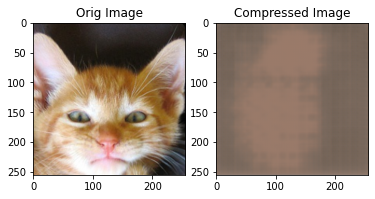

In [0]:
PIC = np.random.choice(20)
print(PIC)
plt.subplot(1,2,1)
plt.imshow(decoder_model.imgs[PIC])
plt.title('Orig Image')

plt.subplot(1,2,2)
plt.imshow(compressed[PIC])
plt.title('Compressed Image')

plt.show()

In [0]:
save_to_git('reduced_size_of_pulls')

Already up to date.
[master 574bf4c] reduced_size_of_pulls
 5 files changed, 236 insertions(+), 23 deletions(-)
 rewrite faces_capstone2/decoder.h5 (76%)
 rewrite faces_capstone2/faces_decoder.ipynb (91%)
 create mode 100644 faces_capstone2/test.csv
 create mode 100644 faces_capstone2/test.h5
 rewrite faces_capstone2/train_log.csv (96%)
Counting objects: 8, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (8/8), done.
Writing objects: 100% (8/8), 2.08 MiB | 1.53 MiB/s, done.
Total 8 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To github.com:rashmi-raviprasad/springboard.git
   7f8fb14..574bf4c  master -> master


In [0]:
os.chdir(REPOSITORY+'/faces_capstone2')
log = pd.read_csv(LOGS_FN)
log.head()

,Date,Run_Number,Num_Epochs_Tot,Train_Loss,Valid_Loss
0,2020-03-10 02:27:40.443648,0,0,NaN,NaN
1,2020-03-10 02:28:16.455108,1,5,0.031323,0.057537
2,2020-03-10 02:28:58.949584,2,10,0.019592,0.059774
3,2020-03-10 02:29:45.312118,3,15,0.015328,0.060629
4,2020-03-10 02:30:29.528276,4,20,0.013094,0.059538


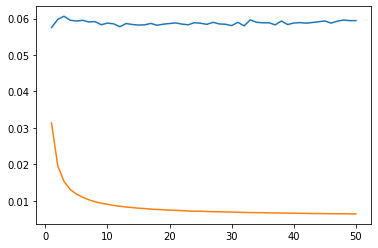

In [0]:
plt.plot(log[['Valid_Loss', 'Train_Loss']])
plt.show()